In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 기본 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

sns.set()

# 그래프 기본 설정
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False
import matplotlib as mpl
import matplotlib.font_manager as fm

# 폰트 파일 경로 지정
font_path = '/content/drive/MyDrive/font/NanumGothic.ttf'

# 폰트 등록 및 matplotlib 설정
font_name = fm.FontProperties(fname=font_path).get_name()
fm.fontManager.addfont(font_path)
mpl.rc('font', family=font_name)
# 경고 뜨지 않게
import warnings
warnings.filterwarnings('ignore')

import os

#✅ 데이터셋 불러오기

In [ ]:
df_total = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/데이터톤/data/total_gmt5.parquet') # 전체데이터

In [ ]:
df_top3 = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/데이터톤/data/주력_비주력상품 데이터/top3_categories.parquet') # 주력 상품 데이터

In [ ]:
df_other = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/데이터톤/data/주력_비주력상품 데이터/other_categories.parquet') # 비주력 상품 데이터

In [ ]:
top_one_df = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/데이터톤/data/주력_비주력상품 데이터/주력상품/one_time_buyers_all_events.parquet') # 주력상품 1회 구매고객 데이터

In [ ]:
top_multi_df = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/데이터톤/data/주력_비주력상품 데이터/주력상품/multi_buyers_all_events.parquet') # 주력상품 2회 이상 구매고객 데이터

In [ ]:
notop_one_df = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/데이터톤/data/주력_비주력상품 데이터/비주력상품/noTop3_one_time_buyers_all_events.parquet') # 비주력상품 1회 구매고객 데이터

In [ ]:
notop_multi_df = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/데이터톤/data/주력_비주력상품 데이터/비주력상품/noTop3_multi_buyers_all_events.parquet') # 비주력상품 2회 이상 구매고객 데이터

# ✅데이터셋 전처리

In [ ]:
# category_lvl3가 결측치인 경우 category_lvl2로 대체
top_one_df['category_lvl3'] = top_one_df['category_lvl3'].fillna(top_one_df['category_lvl2'])

# category_lvl3가 결측치인 경우 category_lvl2로 대체
top_multi_df['category_lvl3'] = top_multi_df['category_lvl3'].fillna(top_multi_df['category_lvl2'])

# category_lvl3가 결측치인 경우 category_lvl2로 대체
notop_one_df['category_lvl3'] = notop_one_df['category_lvl3'].fillna(notop_one_df['category_lvl2'])

# category_lvl3가 결측치인 경우 category_lvl2로 대체
notop_multi_df['category_lvl3'] = notop_multi_df['category_lvl3'].fillna(notop_multi_df['category_lvl2'])

# 📦 EDA 통합

## 📈 전체(주력/비주력 안나누고 본 것)

### 🔎 카테고리별 평균 방문/구매율(막대)

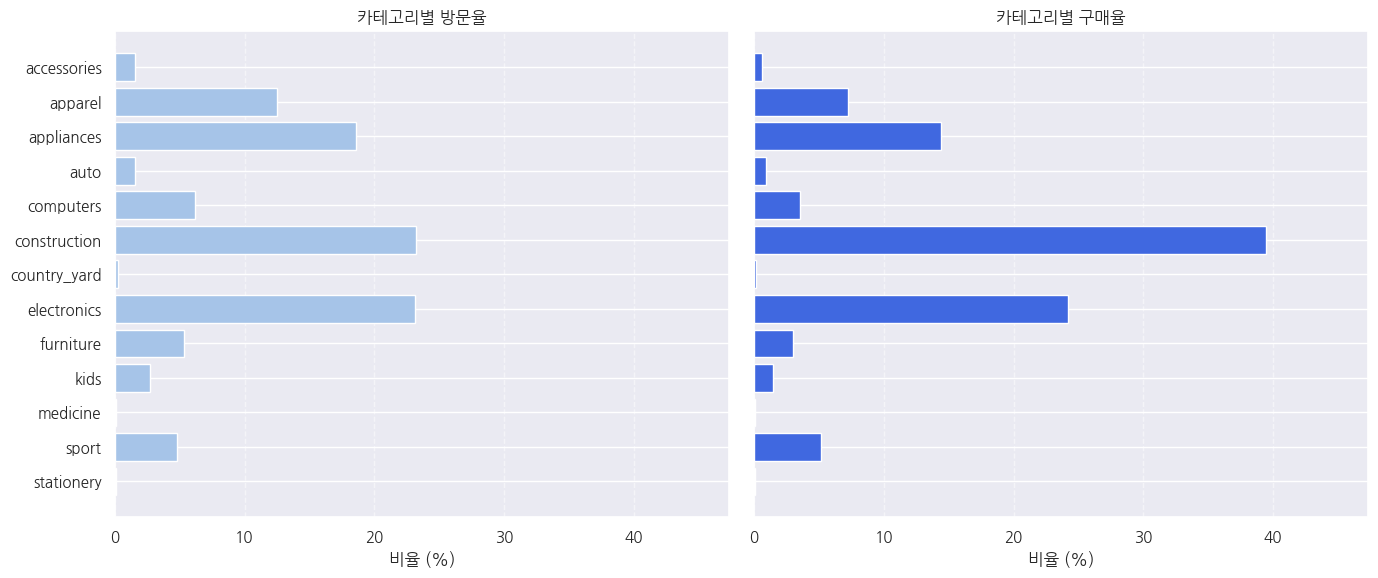

In [ ]:
# 이벤트 타입 기준 필터링
views     = df_total[df_total['event_type'] == 'view']
purchases = df_total[df_total['event_type'] == 'purchase']

# 카테고리별 방문 수 및 구매 수
visit_counts    = views['category_lvl1'].value_counts().sort_index()
purchase_counts = purchases['category_lvl1'].value_counts().sort_index()

# 카테고리 이름 통일
categories = sorted(set(visit_counts.index).union(set(purchase_counts.index)))

visit_counts = visit_counts.reindex(categories, fill_value=0)
purchase_counts = purchase_counts.reindex(categories, fill_value=0)

# 비율 계산 (%)
visit_rate    = 100 * visit_counts / visit_counts.sum()
purchase_rate = 100 * purchase_counts / purchase_counts.sum()

# 시각화 (subplot 양옆)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# 방문율 막대그래프
axes[0].barh(categories, visit_rate, color='#a6c4e8')
axes[0].set_title('카테고리별 방문율')
axes[0].set_xlabel('비율 (%)')
axes[0].invert_yaxis()  # 높은 비율 위로

# 구매율 막대그래프
axes[1].barh(categories, purchase_rate, color='#4068e0')
axes[1].set_title('카테고리별 구매율')
axes[1].set_xlabel('비율 (%)')

# 스타일 개선
for ax in axes:
    ax.grid(axis='x', linestyle='--', alpha=0.5)
    ax.set_xlim(0, max(visit_rate.max(), purchase_rate.max()) * 1.2)

plt.tight_layout()
plt.show()

## 📈 주력상품 EDA

### 💵 1번만 구매

### 🔎카테고리 레벨3별 전환 퍼널 분석(전환율)

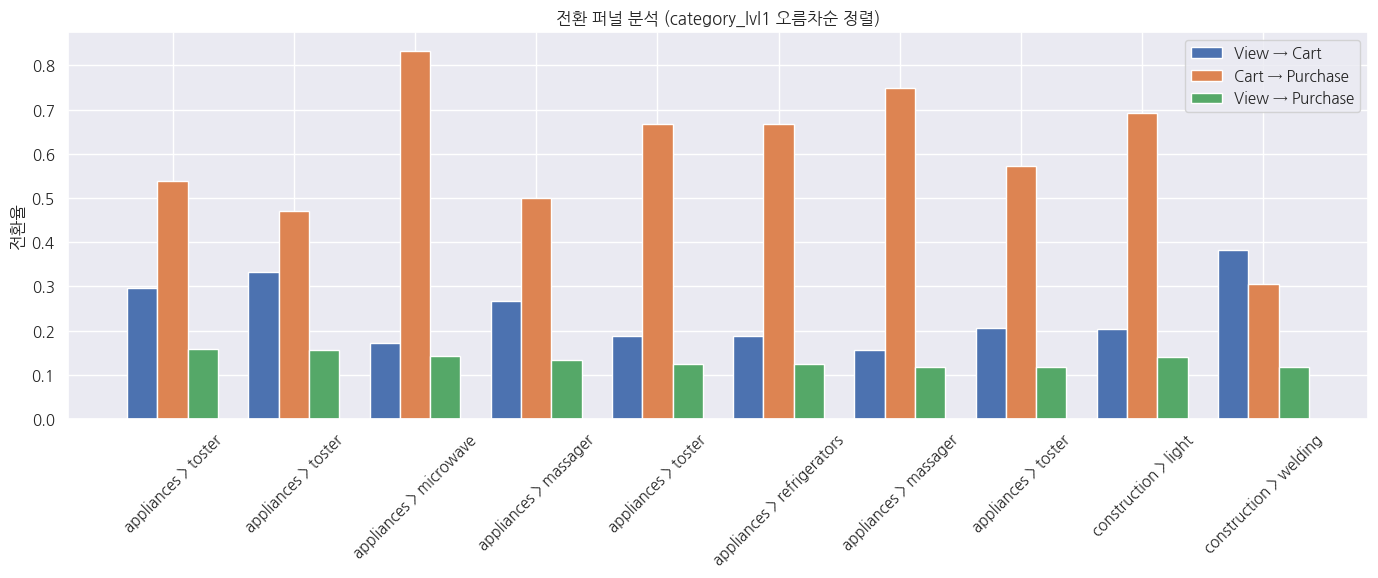

In [ ]:
# 1. 이벤트별 필터링
views = top_one_df[top_one_df['event_type'] == 'view']
carts = top_one_df[top_one_df['event_type'] == 'cart']
purchases = top_one_df[top_one_df['event_type'] == 'purchase']

# 2. 상품별 이벤트 수 집계
view_counts = views.groupby('product_id').size().reset_index(name='view_count')
cart_counts = carts.groupby('product_id').size().reset_index(name='cart_count')
purchase_counts = purchases.groupby('product_id').size().reset_index(name='purchase_count')

# 3. 병합
product_stats = view_counts.merge(cart_counts, on='product_id', how='outer')
product_stats = product_stats.merge(purchase_counts, on='product_id', how='outer')
product_stats.fillna(0, inplace=True)

# 4. 퍼널 전환율 계산
product_stats['view_to_cart_rate'] = product_stats['cart_count'] / product_stats['view_count']
product_stats['cart_to_purchase_rate'] = product_stats['purchase_count'] / product_stats['cart_count']
product_stats['view_to_purchase_rate'] = product_stats['purchase_count'] / product_stats['view_count']

# 5. 상품 정보 결합 (선택)
product_stats = pd.merge(
    product_stats,
    top_one_df[['product_id', 'category_lvl1', 'category_lvl2', 'category_lvl3']].drop_duplicates(),
    on='product_id', how='left'
)

# 6. 결과 확인 (view 수 기준으로 필터링하여 너무 적은 데이터 제거 가능)
product_stats_filtered = product_stats[product_stats['view_count'] >= 30]
# print(product_stats_filtered[['product_id', 'category_lvl3', 'view_to_cart_rate', 'cart_to_purchase_rate', 'view_to_purchase_rate']].sort_values(by='view_to_purchase_rate', ascending=False).head(10))


## 시각화 ##
# 1. 새로운 라벨 컬럼 생성
top_funnel = product_stats_filtered.sort_values(by='view_to_purchase_rate', ascending=False).head(10)

top_funnel['category_label'] = top_funnel['category_lvl1'] + ' > ' + top_funnel['category_lvl3']

# 2. category_lvl1 기준 오름차순 정렬
top_funnel_sorted = top_funnel.sort_values(by='category_lvl1')

# 3. 시각화
plt.figure(figsize=(14, 6))
bar_width = 0.25
x = range(len(top_funnel_sorted))

plt.bar(x, top_funnel_sorted['view_to_cart_rate'], width=bar_width, label='View → Cart')
plt.bar([p + bar_width for p in x], top_funnel_sorted['cart_to_purchase_rate'], width=bar_width, label='Cart → Purchase')
plt.bar([p + bar_width*2 for p in x], top_funnel_sorted['view_to_purchase_rate'], width=bar_width, label='View → Purchase')

# 정렬된 라벨 적용
plt.xticks([p + bar_width for p in x], top_funnel_sorted['category_label'], rotation=45)
plt.ylabel('전환율')
plt.title('전환 퍼널 분석 (category_lvl1 오름차순 정렬)')
plt.legend()
plt.tight_layout()
plt.show()

💡인사이트

| 카테고리                           | View→Cart                      | Cart→Purchase                                  | View→Purchase                           | 인사이트 |
| ------------------------------ | ------------------------------ | ---------------------------------------------- | --------------------------------------- | ---- |
| **appliances > toster**        | 꾸준히 높은 퍼널 흐름 유지                | **50% 이상 전환**                                  | 전반적으로 안정적인 전환 → **리텐션 캠페인 최적 타겟**       |      |
| **appliances > microwave**     | 낮은 View→Cart (관심 적음)           | **매우 높은 Cart→Purchase (\~83%)**                | 초고의사 결정력 → **전면 배치/추천 강화** 전략 필요        |      |
| **appliances > massager**      | 꾸준히 등장하나 View→Purchase 낮음      | 감성소비 상품 → **후기/사용 영상** 중심 캠페인 적합               |                                         |      |
| **appliances > refrigerators** | 낮은 전반 흐름                       | 고가 & 비교 제품 특성 → **긴 구매 주기**, **리타겟팅 중심 전략** 필요 |                                         |      |
| **construction > light**       | View→Cart 낮지만 Cart→Purchase 높음 | 비교적 빠른 전환 → **구매 의도 있는 고객에게 맞춤 쿠폰 효과적**        |                                         |      |
| **construction > welding**     | View→Cart 매우 높음 (**1위**)       | 하지만 Cart→Purchase 급락                           | 가격/정보 부족 추정 → **가격 장벽 해소, 상세 설명 보강 필요** |      |


### 🔎 카테고리 레벨2, 3 매출 총합 순위

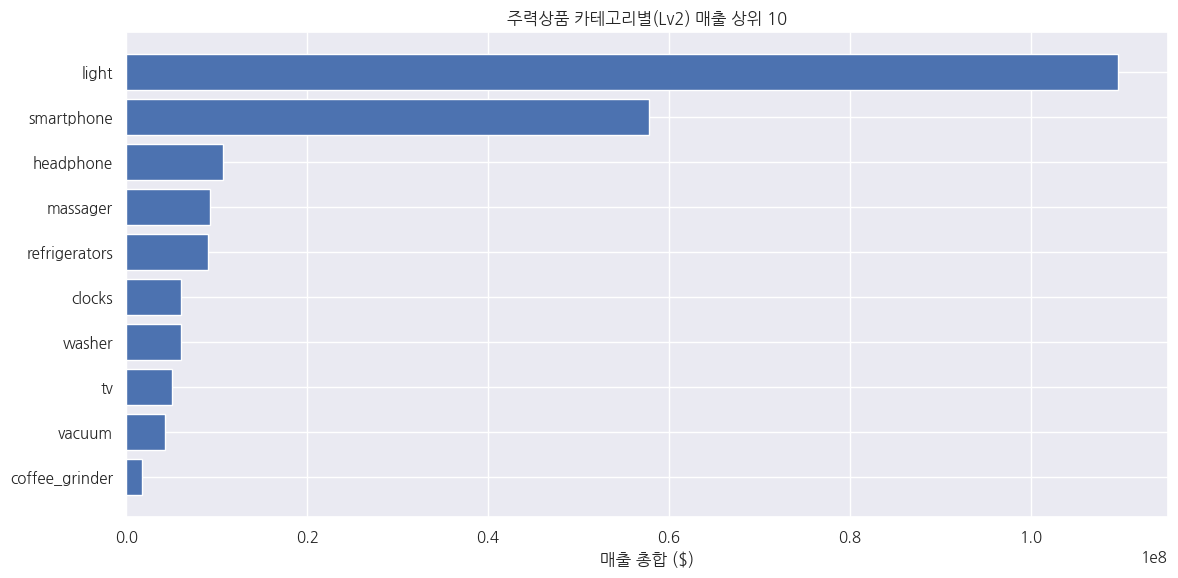

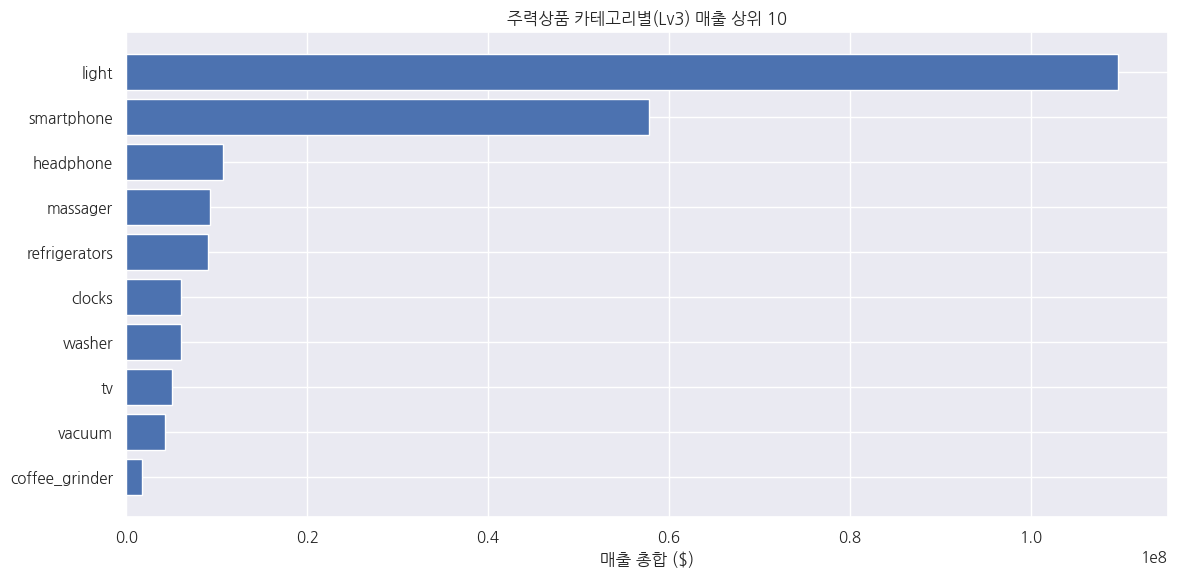

In [ ]:
# 1. 상품별 매출 계산 (price × 건수)
purchase_df = top_one_df[top_one_df['event_type'] == 'purchase']
product_revenue = purchase_df.groupby('product_id')['price'].sum().reset_index(name='total_revenue')

# 2. 상품 정보 붙이기 (카테고리 포함)
product_info = top_one_df[['product_id', 'category_lvl1', 'category_lvl2', 'category_lvl3']].drop_duplicates()
product_revenue = pd.merge(product_revenue, product_info, on='product_id', how='left')

# 3. 매출 총합 상위 10개 상품 출력
top_products = product_revenue.sort_values(by='total_revenue', ascending=False).head(10)
# print(top_products)

# 4. 카테고리별 매출 총합 (category_lvl3 기준)
category_revenue = purchase_df.groupby('category_lvl3')['price'].sum().reset_index(name='total_revenue')
category_revenue = category_revenue.sort_values(by='total_revenue', ascending=False).head(10)

# 5. 시각화
plt.figure(figsize=(12,6))
plt.barh(category_revenue['category_lvl3'], category_revenue['total_revenue'])
plt.xlabel('매출 총합 ($)')
plt.title('주력상품 카테고리별(Lv2) 매출 상위 10')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 4. 카테고리별 매출 총합 (category_lvl3 기준)
category_revenue = purchase_df.groupby('category_lvl3')['price'].sum().reset_index(name='total_revenue')
category_revenue = category_revenue.sort_values(by='total_revenue', ascending=False).head(10)

# 5. 시각화
plt.figure(figsize=(12,6))
plt.barh(category_revenue['category_lvl3'], category_revenue['total_revenue'])
plt.xlabel('매출 총합 ($)')
plt.title('주력상품 카테고리별(Lv3) 매출 상위 10')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 🔎 가격구간별 구매율

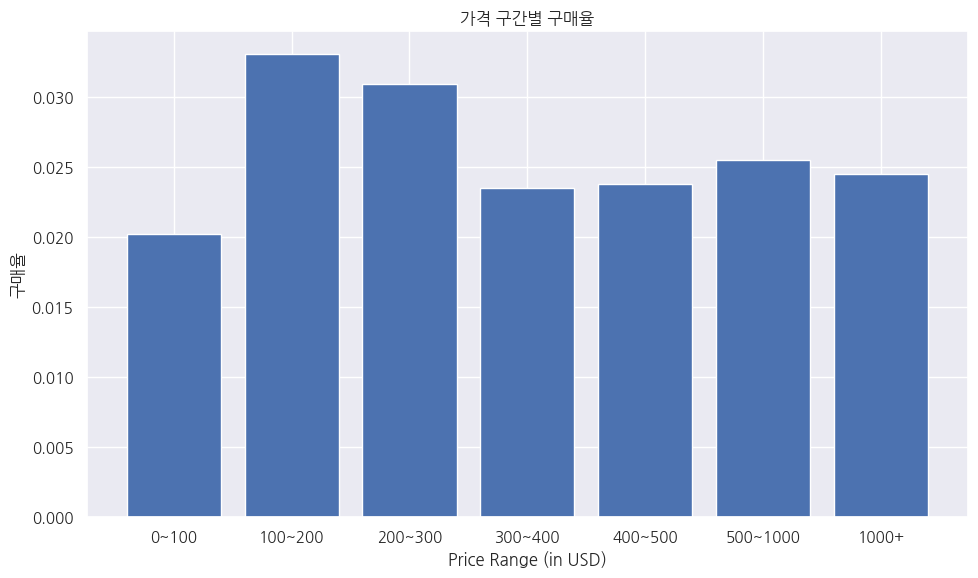

In [ ]:
# 1. 가격 구간 나누기 (10만원 단위, 필요시 조정 가능)
# 올바른 bins와 labels 정의
bins = [0, 100, 200, 300, 400, 500, 1000, float('inf')]  # 8개 → 7개 구간
labels = ['0~100', '100~200', '200~300', '300~400', '400~500', '500~1000', '1000+']  # 7개

# 가격 구간 생성
top_one_df['price_bin'] = pd.cut(top_one_df['price'], bins=bins, labels=labels, right=False)


# 2. 구매, 조회 이벤트만 나누기
purchase_df = top_one_df[top_one_df['event_type'] == 'purchase']
view_df = top_one_df[top_one_df['event_type'] == 'view']

# 3. 가격 구간별 이벤트 수 집계
purchase_stats = purchase_df['price_bin'].value_counts().sort_index().reset_index()
purchase_stats.columns = ['price_bin', 'purchase_count']

view_stats = view_df['price_bin'].value_counts().sort_index().reset_index()
view_stats.columns = ['price_bin', 'view_count']

# 4. 병합 및 구매율 계산
price_group_stats = pd.merge(purchase_stats, view_stats, on='price_bin', how='outer')

# 숫자 컬럼만 골라서 NaN을 0으로 대체
numeric_cols = ['purchase_count', 'view_count']
price_group_stats[numeric_cols] = price_group_stats[numeric_cols].fillna(0)

# 구매율 계산
price_group_stats['conversion_rate'] = price_group_stats['purchase_count'] / price_group_stats['view_count']

# 결과 확인
# print(price_group_stats)

## 시각화 ##
plt.figure(figsize=(10, 6))
plt.bar(price_group_stats['price_bin'].astype(str), price_group_stats['conversion_rate'])
plt.title('가격 구간별 구매율')
plt.xlabel('Price Range (in USD)')
plt.ylabel('구매율')
plt.tight_layout()
plt.show()


💡인사이트

| 전략 대상                   | 제안                                             |
| ----------------------- | ---------------------------------------------- |
| `appliances > toster`   | 자동 리필, 할인 푸시, 구매 간격 기반 알림                      |
| `microwave`, `massager` | 빠른 구매 결정 → **리뷰 기반 맞춤 추천** 또는 **상세 리뷰 강화**     |
| `welding`               | 관심도는 높으나 구매 이탈 많음 → **가격 장벽 해소**, **체험 리뷰 강조** |


### 🔎 고객별 event_type 집계 + 고객별 view-cart-purchase 퍼널 분석(전환율)

In [ ]:
# 퍼널 분석 (view-cart-purchase 단계별 유저 수 및 전환율)
# 사용자별 event_type 집계
funnel_counts = top_one_df.groupby('event_type')['user_id'].nunique().reindex(['view', 'cart', 'purchase'])

# 전환율 계산 (순차적 전환 기준)
view_to_cart = funnel_counts['cart'] / funnel_counts['view'] if funnel_counts['view'] else 0
cart_to_purchase = funnel_counts['purchase'] / funnel_counts['cart'] if funnel_counts['cart'] else 0
view_to_purchase = funnel_counts['purchase'] / funnel_counts['view'] if funnel_counts['view'] else 0

print(funnel_counts)
print(f"view_to_cart: {view_to_cart}")
print(f"cart_to_purchase: {cart_to_purchase}")
print(f"view_to_purchase: {view_to_purchase}")

event_type
view        687495
cart        638191
purchase    690159
Name: user_id, dtype: int64
view_to_cart: 0.9282845693423225
cart_to_purchase: 1.0814301674577047
view_to_purchase: 1.003874937272271


### 🔎구매 전 행동 흐름 분석

In [ ]:
#2. 구매 전 행동 흐름
# 구매가 발생한 세션 이전 이벤트 시퀀스 파악
# 구매 이벤트가 있는 세션 ID 추출
purchase_sessions = top_one_df[top_one_df['event_type'] == 'purchase']['user_session'].unique()

# 해당 세션의 이벤트 순서 (view, cart, purchase)
funnel_sequence = (top_one_df[top_one_df['user_session'].isin(purchase_sessions)]
                   .groupby('user_session')['event_type']
                   .apply(list))

print(funnel_sequence.head(10))  # 세션별 행동 흐름 샘플

user_session
000006f0-e7ff-4ae8-9701-26edf82f6e21    [view, view, view, cart, cart, view, cart, pur...
00005026-a9d1-4e2b-8290-3cc14e4bad89    [view, view, cart, view, view, view, view, car...
00006d34-af00-4973-8617-943ed92f073b    [view, view, cart, view, view, view, cart, pur...
000081ea-9376-4eb8-a69b-0b592765a21d                               [view, cart, purchase]
00008254-8423-4432-bce6-ac31c01cdef7    [view, view, view, view, view, cart, purchase,...
00008dd4-b925-4916-95ce-a5d109c7cfd9                   [view, cart, view, cart, purchase]
00008e06-d2cb-4f9e-b41f-db3382ea5e7a                               [view, cart, purchase]
0000932e-35da-43c0-a4db-2d01abe7f950                                     [purchase, view]
0000b921-b911-437b-9d7f-d9c3f6010fc8                         [view, view, cart, purchase]
0000b966-06a0-4cc8-a917-2503b42ac330                               [view, cart, purchase]
Name: event_type, dtype: object


### 🔎 평균 세션 수

In [ ]:
#3. 세션 수 & 행동량 분석
# 유저별 세션 수
user_session_count = top_one_df.groupby('user_id')['user_session'].nunique()

# 유저별 이벤트 수
user_event_count = top_one_df.groupby('user_id')['event_type'].count()

print(f"평균 세션 수: {user_session_count.mean()}")
print(f"평균 이벤트 수: {user_event_count.mean()}")

평균 세션 수: 8.358289901312595
평균 이벤트 수: 41.108263458130665


### 🔎 평균 탐색 카테고리 수 + 평균 브랜드 수

In [ ]:
#4. 카테고리/브랜드 다양성
# 유저별 탐색 카테고리 수
user_category_diversity = top_one_df.groupby('user_id')['category_lvl1'].nunique()

# 유저별 브랜드 수
user_brand_diversity = top_one_df.groupby('user_id')['brand'].nunique()

print(f"평균 탐색 카테고리 수: {user_category_diversity.mean()}")
print(f"평균 브랜드 수: {user_brand_diversity.mean()}")

평균 탐색 카테고리 수: 1.8552666849233292
평균 브랜드 수: 5.73592896709309


## 💸 2번이상 구매

### 🔎 카테고리 레벨 3별 전환 퍼널 분석(전환율)

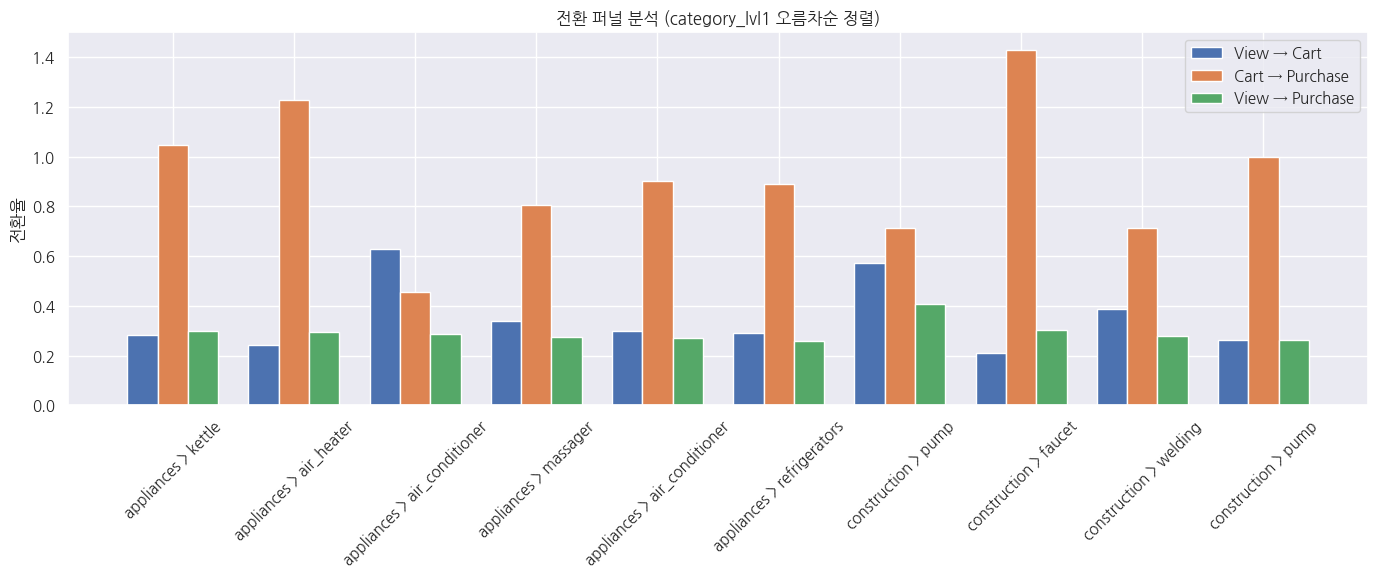

In [ ]:
# 1. 이벤트별 필터링
views = top_multi_df[top_multi_df['event_type'] == 'view']
carts = top_multi_df[top_multi_df['event_type'] == 'cart']
purchases = top_multi_df[top_multi_df['event_type'] == 'purchase']

# 2. 상품별 이벤트 수 집계
view_counts = views.groupby('product_id').size().reset_index(name='view_count')
cart_counts = carts.groupby('product_id').size().reset_index(name='cart_count')
purchase_counts = purchases.groupby('product_id').size().reset_index(name='purchase_count')

# 3. 병합
product_stats = view_counts.merge(cart_counts, on='product_id', how='outer')
product_stats = product_stats.merge(purchase_counts, on='product_id', how='outer')
product_stats.fillna(0, inplace=True)

# 4. 퍼널 전환율 계산
product_stats['view_to_cart_rate'] = product_stats['cart_count'] / product_stats['view_count']
product_stats['cart_to_purchase_rate'] = product_stats['purchase_count'] / product_stats['cart_count']
product_stats['view_to_purchase_rate'] = product_stats['purchase_count'] / product_stats['view_count']

# 5. 상품 정보 결합 (선택)
product_stats = pd.merge(
    product_stats,
    top_multi_df[['product_id', 'category_lvl1', 'category_lvl2', 'category_lvl3']].drop_duplicates(),
    on='product_id', how='left'
)

# 6. 결과 확인 (view 수 기준으로 필터링하여 너무 적은 데이터 제거 가능)
product_stats_filtered = product_stats[product_stats['view_count'] >= 30]
# print(product_stats_filtered[['product_id', 'category_lvl3', 'view_to_cart_rate', 'cart_to_purchase_rate', 'view_to_purchase_rate']].sort_values(by='view_to_purchase_rate', ascending=False).head(10))


## 시각화 ##
top_funnel = product_stats_filtered.sort_values(by='view_to_purchase_rate', ascending=False).head(10)

# 1. 새로운 라벨 컬럼 생성
top_funnel['category_label'] = top_funnel['category_lvl1'] + ' > ' + top_funnel['category_lvl3']

# 2. category_lvl1 기준 오름차순 정렬
top_funnel_sorted = top_funnel.sort_values(by='category_lvl1')

# 3. 시각화
plt.figure(figsize=(14, 6))
bar_width = 0.25
x = range(len(top_funnel_sorted))

plt.bar(x, top_funnel_sorted['view_to_cart_rate'], width=bar_width, label='View → Cart')
plt.bar([p + bar_width for p in x], top_funnel_sorted['cart_to_purchase_rate'], width=bar_width, label='Cart → Purchase')
plt.bar([p + bar_width*2 for p in x], top_funnel_sorted['view_to_purchase_rate'], width=bar_width, label='View → Purchase')

# 정렬된 라벨 적용
plt.xticks([p + bar_width for p in x], top_funnel_sorted['category_label'], rotation=45)
plt.ylabel('전환율')
plt.title('전환 퍼널 분석 (category_lvl1 오름차순 정렬)')
plt.legend()
plt.tight_layout()
plt.show()

### 🔎 가격 구간별 전환율

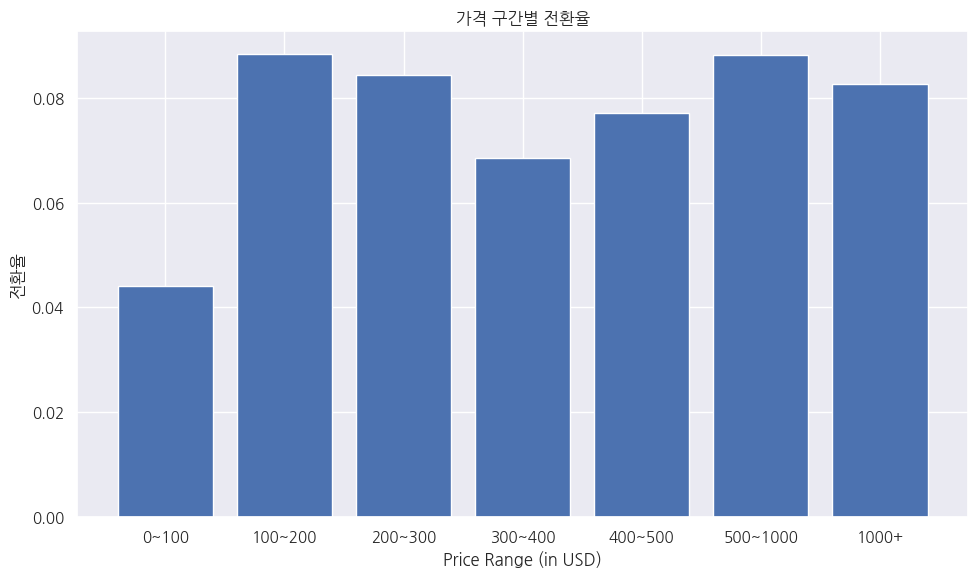

In [ ]:
# 1. 가격 구간 나누기 (10만원 단위, 필요시 조정 가능)
# 올바른 bins와 labels 정의
bins = [0, 100, 200, 300, 400, 500, 1000, float('inf')]  # 8개 → 7개 구간
labels = ['0~100', '100~200', '200~300', '300~400', '400~500', '500~1000', '1000+']  # 7개

# 가격 구간 생성
top_multi_df['price_bin'] = pd.cut(top_multi_df['price'], bins=bins, labels=labels, right=False)


# 2. 구매, 조회 이벤트만 나누기
purchase_df = top_multi_df[top_multi_df['event_type'] == 'purchase']
view_df = top_multi_df[top_multi_df['event_type'] == 'view']

# 3. 가격 구간별 이벤트 수 집계
purchase_stats = purchase_df['price_bin'].value_counts().sort_index().reset_index()
purchase_stats.columns = ['price_bin', 'purchase_count']

view_stats = view_df['price_bin'].value_counts().sort_index().reset_index()
view_stats.columns = ['price_bin', 'view_count']

# 4. 병합 및 구매율 계산
price_group_stats = pd.merge(purchase_stats, view_stats, on='price_bin', how='outer')

# 숫자 컬럼만 골라서 NaN을 0으로 대체
numeric_cols = ['purchase_count', 'view_count']
price_group_stats[numeric_cols] = price_group_stats[numeric_cols].fillna(0)

# 구매율 계산
price_group_stats['conversion_rate'] = price_group_stats['purchase_count'] / price_group_stats['view_count']

# 결과 확인
# print(price_group_stats)


## 시각화 ##
plt.figure(figsize=(10, 6))
plt.bar(price_group_stats['price_bin'].astype(str), price_group_stats['conversion_rate'])
plt.title('가격 구간별 전환율')
plt.xlabel('Price Range (in USD)')
plt.ylabel('전환율')
plt.tight_layout()
plt.show()

### 🔎 고객유형별 레벨3 상품 구매 건수
다양한 상품 구매 고객 vs 같은 상품 반복 고객 구분
→ 고객 타입별 리텐션 전략 차별화

제품군이 다양한 고객 vs 집중된 고객 비교
→ 어떤 그룹이 재구매 가능성 높은지 파악

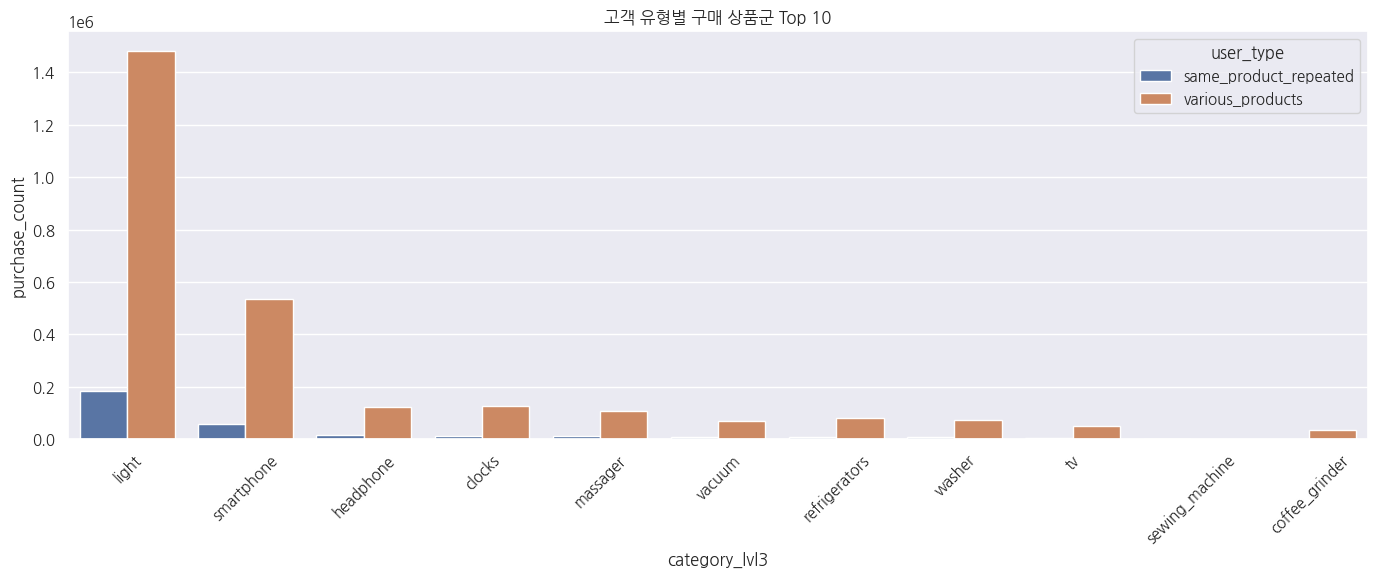

In [ ]:
# 구매 데이터만 필터링
purchase_df = top_multi_df[top_multi_df['event_type'] == 'purchase']

# 고객별 총 구매 수
user_total_purchases = purchase_df.groupby('user_id')['product_id'].count().reset_index(name='total_purchases')

# 고객별 고유한 product_id 수
user_unique_products = purchase_df.groupby('user_id')['product_id'].nunique().reset_index(name='unique_products')

# 병합
user_profile = pd.merge(user_total_purchases, user_unique_products, on='user_id')

# 고객 유형 분류
def classify_user(row):
    if row['unique_products'] == 1:
        return 'same_product_repeated'
    else:
        return 'various_products'

user_profile['user_type'] = user_profile.apply(classify_user, axis=1)

# 결과 확인
# print(user_profile['user_type'].value_counts())

# user_type 정보 결합
purchase_df = purchase_df.merge(user_profile[['user_id', 'user_type']], on='user_id', how='left')

# 사용자 유형 + 카테고리 기준으로 집계
user_type_cat = purchase_df.groupby(['user_type', 'category_lvl3']).size().reset_index(name='purchase_count')

# 상위 10개씩 확인
# print(user_type_cat.sort_values(by='purchase_count', ascending=False).groupby('user_type').head(10))

## 시각화 ##
# 상위 10개만 시각화
top_cats = user_type_cat.groupby('user_type').apply(lambda x: x.sort_values(by='purchase_count', ascending=False).head(10)).reset_index(drop=True)

plt.figure(figsize=(14, 6))
sns.barplot(data=top_cats, x='category_lvl3', y='purchase_count', hue='user_type')
plt.title('고객 유형별 구매 상품군 Top 10')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

💡 인사이트

| 고객유형                    | 반복 구매한 상품군  | 전략 제안                    |
| ----------------------- | ----------- | ------------------------ |
| same\_product\_repeated | 소모품/생활필수품 등 | 재구매 유도, 리마인드 캠페인, 구독 서비스 |
| various\_products       | 카테고리 다양함    | 추천 상품 시스템, 유사 상품 큐레이션    |


### 🔎 고객 수익성 상위 카테고리 3

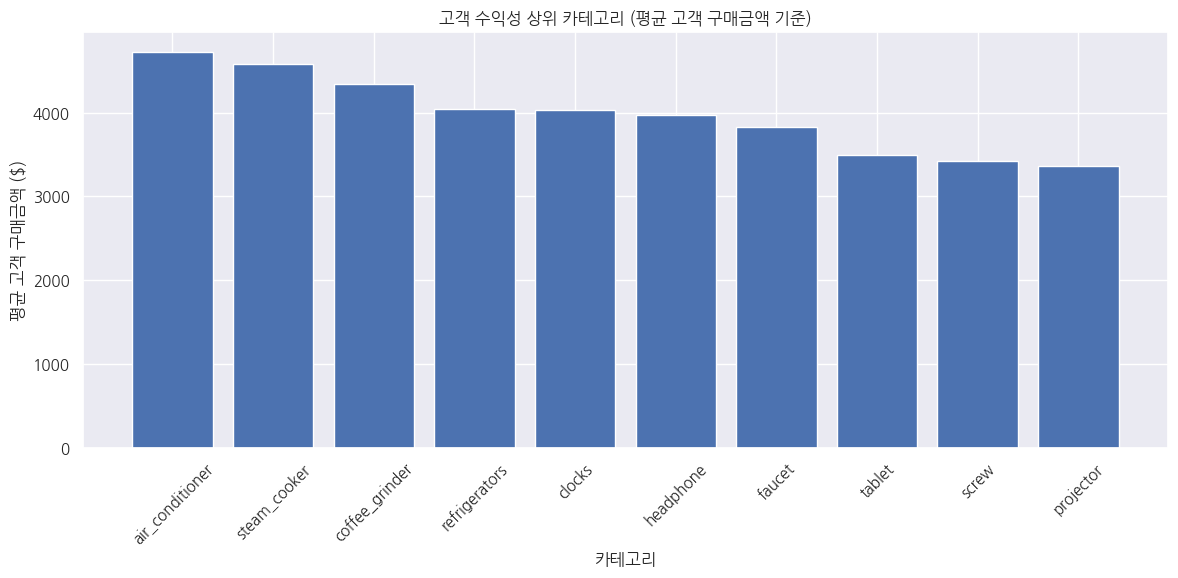

In [ ]:
# 유저별 전체 구매금액
user_value = purchase_df.groupby('user_id')['price'].sum().reset_index()
user_value.columns = ['user_id', 'total_spent']

# 카테고리별 평균 고객 구매금액 계산
avg_value_cat = purchase_df.groupby('category_lvl3')['user_id'].apply(
    lambda x: user_value[user_value['user_id'].isin(x)]['total_spent'].mean()
).reset_index(name='avg_user_value')

# 상위 카테고리 10개 시각화
top_value_cat = avg_value_cat.sort_values('avg_user_value', ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.bar(top_value_cat['category_lvl3'].astype(str), top_value_cat['avg_user_value'])
plt.title('고객 수익성 상위 카테고리 (평균 고객 구매금액 기준)')
plt.xlabel('카테고리')
plt.ylabel('평균 고객 구매금액 ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 🔎 카테고리 레벨2, 3별 매출 총합 순위

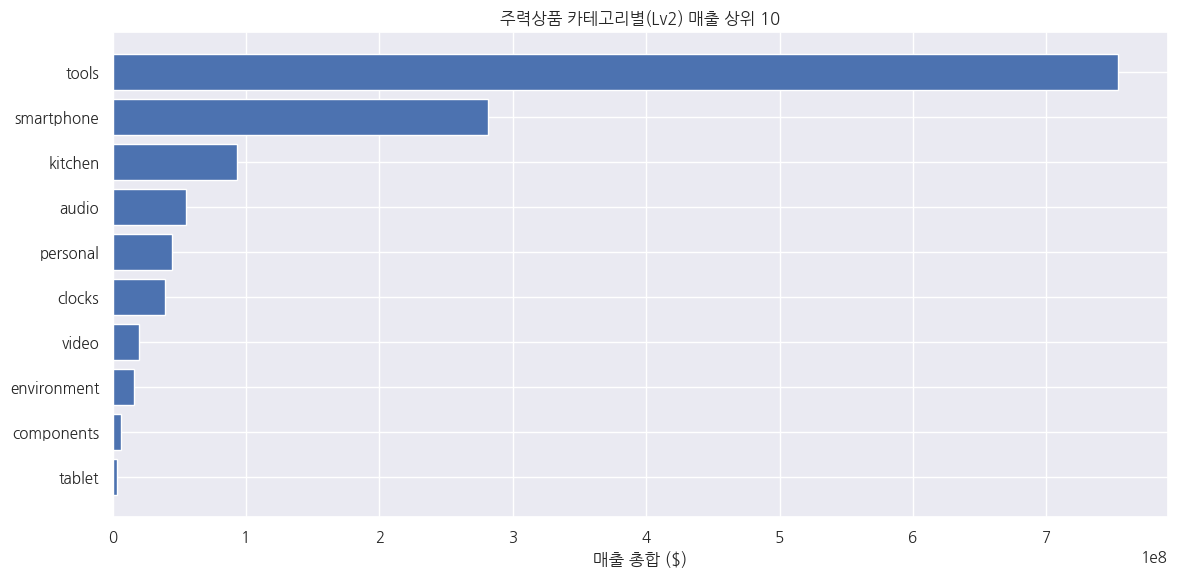

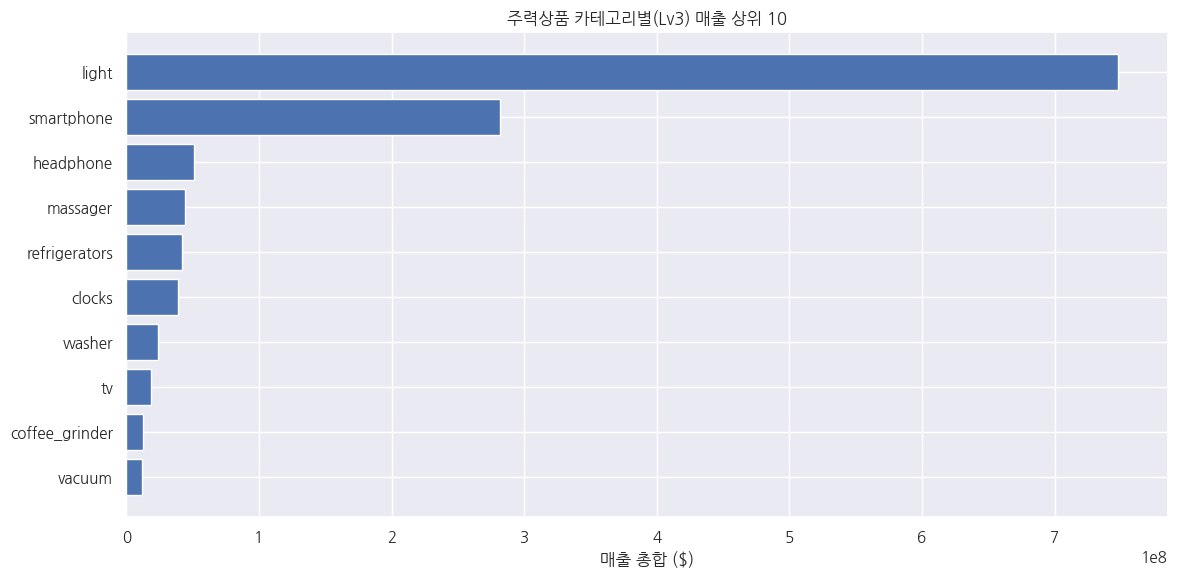

In [ ]:
# 4. 카테고리별 매출 총합 (category_lvl2 기준)
category_revenue = purchase_df.groupby('category_lvl2')['price'].sum().reset_index(name='total_revenue')
category_revenue = category_revenue.sort_values(by='total_revenue', ascending=False).head(10)

# 5. 시각화
plt.figure(figsize=(12,6))
plt.barh(category_revenue['category_lvl2'], category_revenue['total_revenue'])
plt.xlabel('매출 총합 ($)')
plt.title('주력상품 카테고리별(Lv2) 매출 상위 10')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 4. 카테고리별 매출 총합 (category_lvl3 기준)
category_revenue = purchase_df.groupby('category_lvl3')['price'].sum().reset_index(name='total_revenue')
category_revenue = category_revenue.sort_values(by='total_revenue', ascending=False).head(10)

# 5. 시각화
plt.figure(figsize=(12,6))
plt.barh(category_revenue['category_lvl3'], category_revenue['total_revenue'])
plt.xlabel('매출 총합 ($)')
plt.title('주력상품 카테고리별(Lv3) 매출 상위 10')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 🔎 고객별 event_type 집계 + 고객별 view-cart-purchase 퍼널 분석(전환율)

In [ ]:
# 퍼널 분석 (view-cart-purchase 단계별 유저 수 및 전환율)
# 사용자별 event_type 집계
funnel_counts = top_multi_df.groupby('event_type')['user_id'].nunique().reindex(['view', 'cart', 'purchase'])

# 전환율 계산 (순차적 전환 기준)
view_to_cart = funnel_counts['cart'] / funnel_counts['view'] if funnel_counts['view'] else 0
cart_to_purchase = funnel_counts['purchase'] / funnel_counts['cart'] if funnel_counts['cart'] else 0
view_to_purchase = funnel_counts['purchase'] / funnel_counts['view'] if funnel_counts['view'] else 0

print(funnel_counts)
print(f"view_to_cart: {view_to_cart}")
print(f"cart_to_purchase: {cart_to_purchase}")
print(f"view_to_purchase: {view_to_purchase}")

event_type
view        644650
cart        633968
purchase    645198
Name: user_id, dtype: int64
view_to_cart: 0.9834297680912123
cart_to_purchase: 1.017713827827272
view_to_purchase: 1.000850073683394


### 🔎평균 재구매 주기(일)

In [ ]:
#1.구매 간격(재구매 주기)
# event_date를 datetime으로 변환
top_multi_df['event_date'] = pd.to_datetime(top_multi_df['event_date'])

# 구매 이벤트만 추출
purchase_top_multi_df = top_multi_df[top_multi_df['event_type'] == 'purchase']

# 유저별 구매 일자 정렬
purchase_top_multi_df = purchase_top_multi_df.sort_values(by=['user_id', 'event_date'])

# 각 유저의 구매 간격 계산 (days)
purchase_top_multi_df['purchase_gap'] = purchase_top_multi_df.groupby('user_id')['event_date'].diff().dt.days

# 평균 구매 간격
avg_gap = purchase_top_multi_df['purchase_gap'].mean()
print(f"평균 구매 간격(일): {avg_gap}")

평균 구매 간격(일): 7.867477718307534


### 🔎 구매 전 행동 흐름 분석

In [ ]:
#2. 구매 전 행동 흐름
# 구매가 발생한 세션 이전 이벤트 시퀀스 파악
# 구매 이벤트가 있는 세션 ID 추출
purchase_sessions = top_multi_df[top_multi_df['event_type'] == 'purchase']['user_session'].unique()

# 해당 세션의 이벤트 순서 (view, cart, purchase)
funnel_sequence = (top_multi_df[top_multi_df['user_session'].isin(purchase_sessions)]
                   .groupby('user_session')['event_type']
                   .apply(list))

print(funnel_sequence.head(10))  # 세션별 행동 흐름 샘플

user_session
00000083-8816-4d58-a9b8-f52f54186edc    [view, view, view, view, view, view, view, vie...
000001fd-1f89-45e8-a3ce-fe3218cabfad    [view, view, view, view, cart, view, cart, car...
0000138c-b861-4c6a-8abb-ed43b1def8e2                         [view, view, cart, purchase]
00001b7d-1090-45e1-8130-0b683911631f                               [view, cart, purchase]
00002469-20b6-4603-8fa1-51e78f062bd2    [view, cart, purchase, view, cart, purchase, v...
00002495-fc82-44f0-b008-7a09baca1cb6                               [view, cart, purchase]
0000256d-010c-47da-bcef-cf2c1017bcf6    [view, view, view, view, view, view, cart, pur...
0000266c-6ae3-48f2-abc6-44189d2ff64a    [view, cart, cart, view, cart, purchase, view,...
00002680-2bc1-4c1e-9195-31f3c9399018                   [view, cart, purchase, view, view]
00002b33-422d-4a07-a3c1-0193afd045d3    [view, view, view, view, view, view, view, car...
Name: event_type, dtype: object


### 🔎 평균 세션 수

In [ ]:
#3. 세션 수 & 행동량 분석
# 유저별 세션 수
user_session_count = top_multi_df.groupby('user_id')['user_session'].nunique()

# 유저별 이벤트 수
user_event_count = top_multi_df.groupby('user_id')['event_type'].count()

print(f"평균 세션 수: {user_session_count.mean()}")
print(f"평균 이벤트 수: {user_event_count.mean()}")

평균 세션 수: 15.730442437825287
평균 이벤트 수: 83.50625234424162


### 🔎평균 탐색 카테고리 수 + 평균 브랜드 수

In [ ]:
#4. 카테고리/브랜드 다양성
# 유저별 탐색 카테고리 수
user_category_diversity = top_multi_df.groupby('user_id')['category_lvl1'].nunique()

# 유저별 브랜드 수
user_brand_diversity = top_multi_df.groupby('user_id')['brand'].nunique()

print(f"평균 탐색 카테고리 수: {user_category_diversity.mean()}")
print(f"평균 브랜드 수: {user_brand_diversity.mean()}")

평균 탐색 카테고리 수: 2.1977997451944984
평균 브랜드 수: 8.471027498535333


### 🔎 다회 구매자의 첫 구매 행동 패턴 분석



In [ ]:
# 첫 구매 이전 cart -> purchase 시간 계산
# 1. event_datetime 컬럼 생성
top_multi_df['event_datetime'] = top_multi_df['event_date'] + pd.to_timedelta(top_multi_df['event_hour'], unit='h')
top_multi_df['event_datetime'] = pd.to_datetime(top_multi_df['event_datetime'])

# 2. 각 유저의 첫 purchase 시간 구하기
first_purchase_time = top_multi_df[top_multi_df['event_type'] == 'purchase'] \
                        .groupby('user_id')['event_datetime'].min() \
                        .rename('first_purchase_time')

# 3. 첫 구매 이전의 행동만 필터링
top_multi_df = top_multi_df.join(first_purchase_time, on='user_id')
top_multi_df_first_purchase = top_multi_df[top_multi_df['event_datetime'] <= top_multi_df['first_purchase_time']].copy()

# 4. 해당 구간 내에서 cart/purchase 시점 추출
df_cart = top_multi_df_first_purchase[top_multi_df_first_purchase['event_type'] == 'cart']
df_purchase = top_multi_df_first_purchase[top_multi_df_first_purchase['event_type'] == 'purchase']

cart_times = df_cart.groupby('user_id')['event_datetime'].min()
purchase_times = df_purchase.groupby('user_id')['event_datetime'].min()

# 5. 공통 user_id 기준 병합 및 시간 차 계산 (단위: 시간)
merged = pd.merge(cart_times, purchase_times, on='user_id', suffixes=('_cart', '_purchase'))
cart_hold_time_first_purchase = (merged['event_datetime_purchase'] - merged['event_datetime_cart']).dt.total_seconds() / 3600

In [ ]:
print("평균 Cart 보유 시간 (시간):", cart_hold_time_first_purchase.mean())

평균 Cart 보유 시간 (시간): 131.43819934974195


In [ ]:
print(cart_hold_time_first_purchase.describe())

count    573926.000000
mean        131.438199
std         428.595918
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max        4297.000000
dtype: float64


In [ ]:
# 즉시 구매자 비율 확인
instant_buyers_ratio = (cart_hold_time_first_purchase == 0).mean() * 100
print(f"즉시 구매자 비율: {instant_buyers_ratio:.2f}%")

즉시 구매자 비율: 69.10%


## 🧾 통합

### 🔎 2회 이상 구매자의 첫-> 두번째 구매에서 카테고리 변경 비율, 경로

2회 이상 구매자의 첫→두번째 구매에서 카테고리 변경 비율: 0.219

상세 분포:
category_changed
False    503688
True     141510
Name: count, dtype: int64


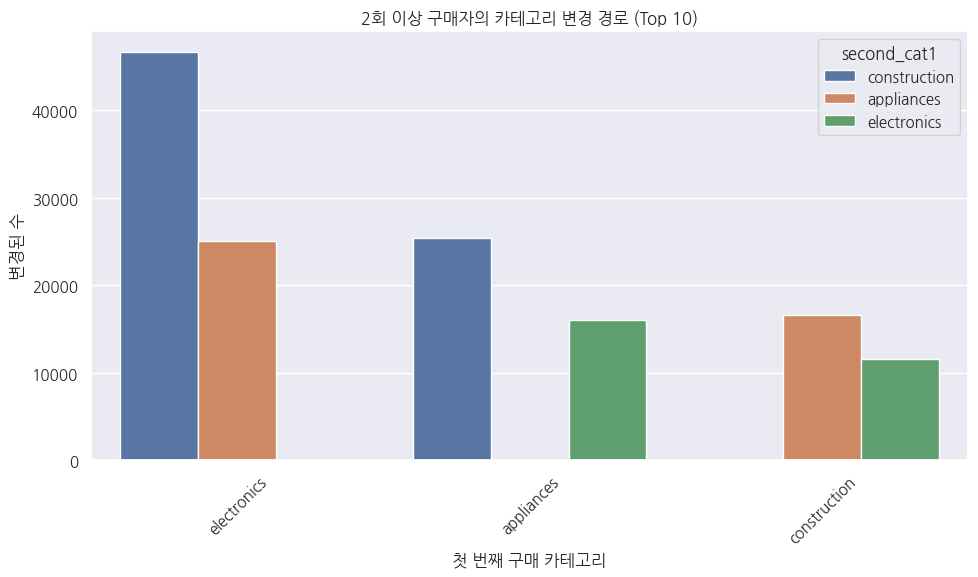

In [ ]:
# 구매 이벤트만 필터링
multi_purchase = top_multi_df[top_multi_df['event_type'] == 'purchase'].copy()

# 날짜 정렬
multi_purchase['event_date'] = pd.to_datetime(multi_purchase['event_date'])
multi_purchase = multi_purchase.sort_values(by=['user_id', 'event_date'])

# 유저별 구매 순서 부여
multi_purchase['purchase_order'] = multi_purchase.groupby('user_id').cumcount() + 1

# 첫 번째, 두 번째 구매만 추출
first_second = multi_purchase[multi_purchase['purchase_order'] <= 2]

# 첫/두 번째 구매를 하나의 행에 피벗
pivoted = first_second.pivot(index='user_id', columns='purchase_order', values='category_lvl1')
pivoted.columns = ['first_cat1', 'second_cat1']
pivoted = pivoted.dropna()

# 변경 여부 판단
pivoted['category_changed'] = pivoted['first_cat1'] != pivoted['second_cat1']

# 통계 요약
change_rate = pivoted['category_changed'].mean()
change_counts = pivoted['category_changed'].value_counts()

print("2회 이상 구매자의 첫→두번째 구매에서 카테고리 변경 비율:", round(change_rate, 3))
print("\n상세 분포:")
print(change_counts)

# 변경된 경우만 추출
changed_cases = pivoted[pivoted['category_changed']]

# 변화 경로 집계
change_paths = changed_cases.groupby(['first_cat1', 'second_cat1']).size().reset_index(name='count')
change_paths = change_paths.sort_values('count', ascending=False)

# 상위 몇 개만 시각화
top_paths = change_paths.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_paths, y='count', x='first_cat1', hue='second_cat1')
plt.title('2회 이상 구매자의 카테고리 변경 경로 (Top 10)')
plt.xlabel('첫 번째 구매 카테고리')
plt.ylabel('변경된 수')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 🔎 고객별 view-cart-purchase 퍼널 분석(막대 그래프)

<function matplotlib.pyplot.show(close=None, block=None)>

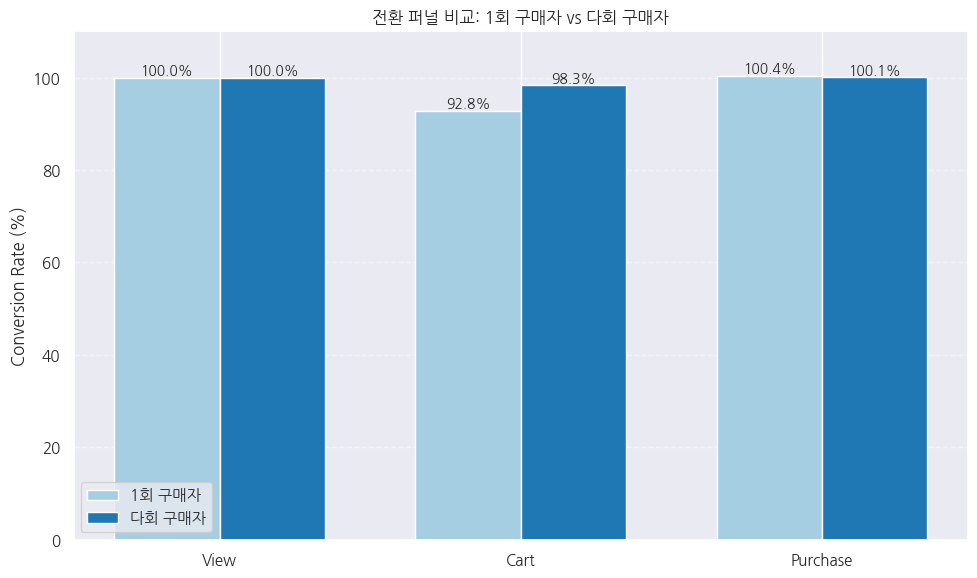

In [ ]:
# 단계별 정의
stages = ['View', 'Cart', 'Purchase']
x = np.arange(len(stages))

# 전환율 (View 기준 100%)
one_time_rates = [1.0, 0.9283, 1.0039]     # 1회 구매자
multi_rates    = [1.0, 0.9834, 1.0009]     # 다회 구매자

# 막대 너비 설정
width = 0.35

# 시각화
plt.figure(figsize=(10, 6))
bars1 = plt.bar(x - width/2, [r * 100 for r in one_time_rates], width, label='1회 구매자', color='#a6cee3')
bars2 = plt.bar(x + width/2, [r * 100 for r in multi_rates], width, label='다회 구매자', color='#1f78b4')

# 텍스트 라벨링
for i in range(len(stages)):
    plt.text(x[i] - width/2, one_time_rates[i] * 100 + 0.5, f'{one_time_rates[i]*100:.1f}%', ha='center', fontsize=10)
    plt.text(x[i] + width/2, multi_rates[i] * 100 + 0.5, f'{multi_rates[i]*100:.1f}%', ha='center', fontsize=10)

# 그래프 설정
plt.xticks(x, stages)
plt.ylabel('Conversion Rate (%)')
plt.title('전환 퍼널 비교: 1회 구매자 vs 다회 구매자')
plt.ylim(0, 110)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show

### 🔎 고객별 view-cart-purchase 퍼널 분석(선 그래프)

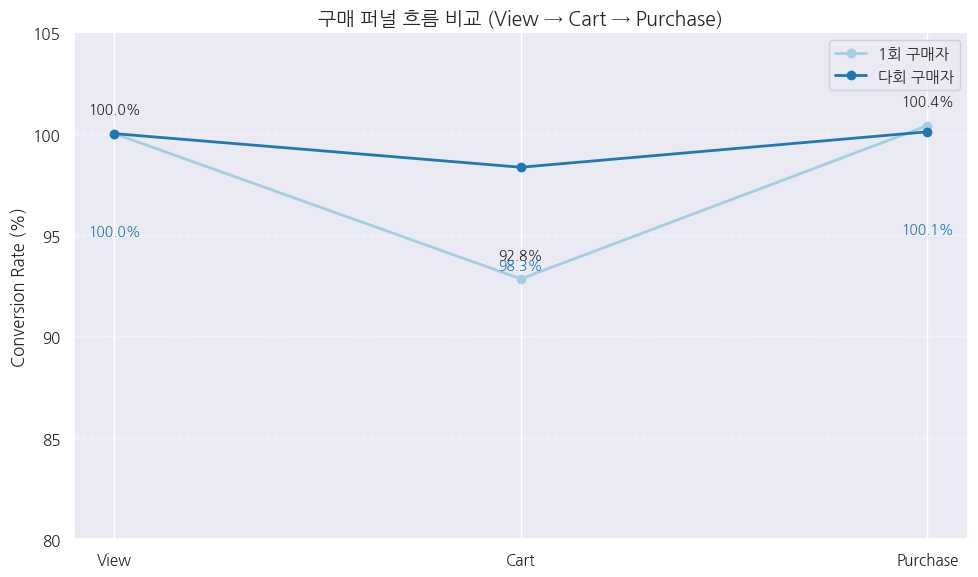

In [ ]:
# 어느 단계에서 유저가 빠지는지 강조하기 좋은 퍼널형 그래프
import matplotlib.pyplot as plt

# 단계와 전환율 정의 (% 단위)
stages = ['View', 'Cart', 'Purchase']
one_time_rates = [100, 92.83, 100.39]     # 실제 분석 결과 기반
multi_rates    = [100, 98.34, 100.09]

plt.figure(figsize=(10, 6))

# 선 그래프 그리기
plt.plot(stages, one_time_rates, marker='o', label='1회 구매자', color='#a6cee3', linewidth=2)
plt.plot(stages, multi_rates, marker='o', label='다회 구매자', color='#1f78b4', linewidth=2)

# 각 지점에 값 표시
for i in range(len(stages)):
    plt.text(i, one_time_rates[i] + 1, f'{one_time_rates[i]:.1f}%', ha='center', fontsize=10)
    plt.text(i, multi_rates[i] - 5, f'{multi_rates[i]:.1f}%', ha='center', fontsize=10, color='#1f78b4')

# 시각화 설정
plt.ylim(80, 105)  # y축 고정 → 과장 방지
plt.ylabel('Conversion Rate (%)')
plt.title('구매 퍼널 흐름 비교 (View → Cart → Purchase)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

### 🔎 평균 cart 보유 시간 비교(수치 확인)

In [ ]:
df = top_multi_df  # 다회 구매자용 전체 데이터

# 1. event_datetime 생성 (vectorized 방식)
df['event_datetime'] = pd.to_datetime(df['event_date']) + pd.to_timedelta(df['event_hour'], unit='h')

# 2. cart & purchase 이벤트 필터링
df_cart = df[df['event_type'] == 'cart']
df_purchase = df[df['event_type'] == 'purchase']

# 3. 세션별 가장 빠른 cart/purchase 시간 추출
cart_times = df_cart.groupby('user_session')['event_datetime'].min().to_frame(name='cart_time')
purchase_times = df_purchase.groupby('user_session')['event_datetime'].min().to_frame(name='purchase_time')

# 4. 공통 세션만 남기고 merge
merged = pd.merge(cart_times, purchase_times, left_index=True, right_index=True)

# 5. 시간차 계산
cart_hold_time = (merged['purchase_time'] - merged['cart_time']).dt.total_seconds() / 3600

# 6. 음수 제거 (올바른 순서만 필터링)
cart_hold_time = cart_hold_time[cart_hold_time >= 0]

# 7. 결과 출력
print(f"[다회 구매자] 평균 Cart 보유 시간 (시간): {cart_hold_time.mean():.2f}")

[다회 구매자] 평균 Cart 보유 시간 (시간): 1.46


In [ ]:
cart_hold_time_multi = cart_hold_time # 다회 구매자

In [ ]:
df = top_one_df  # 1회 구매자용 전체 데이터

# 1. event_datetime 생성 (vectorized 방식)
df['event_datetime'] = pd.to_datetime(df['event_date']) + pd.to_timedelta(df['event_hour'], unit='h')

# 2. cart & purchase 이벤트 필터링
df_cart = df[df['event_type'] == 'cart']
df_purchase = df[df['event_type'] == 'purchase']

# 3. 세션별 가장 빠른 cart/purchase 시간 추출
cart_times = df_cart.groupby('user_session')['event_datetime'].min().to_frame(name='cart_time')
purchase_times = df_purchase.groupby('user_session')['event_datetime'].min().to_frame(name='purchase_time')

# 4. 공통 세션만 남기고 merge
merged = pd.merge(cart_times, purchase_times, left_index=True, right_index=True)

# 5. 시간차 계산
cart_hold_time = (merged['purchase_time'] - merged['cart_time']).dt.total_seconds() / 3600

# 6. 음수 제거 (올바른 순서만 필터링)
cart_hold_time = cart_hold_time[cart_hold_time >= 0]

# 7. 결과 출력
print(f"[1회 구매자] 평균 Cart 보유 시간 (시간): {cart_hold_time.mean():.2f}")

[1회 구매자] 평균 Cart 보유 시간 (시간): 2.56


In [ ]:
cart_hold_time_one_time = cart_hold_time #1회 구매자

### 🔎 평균 cart 보유 시간 비교(막대 그래프)

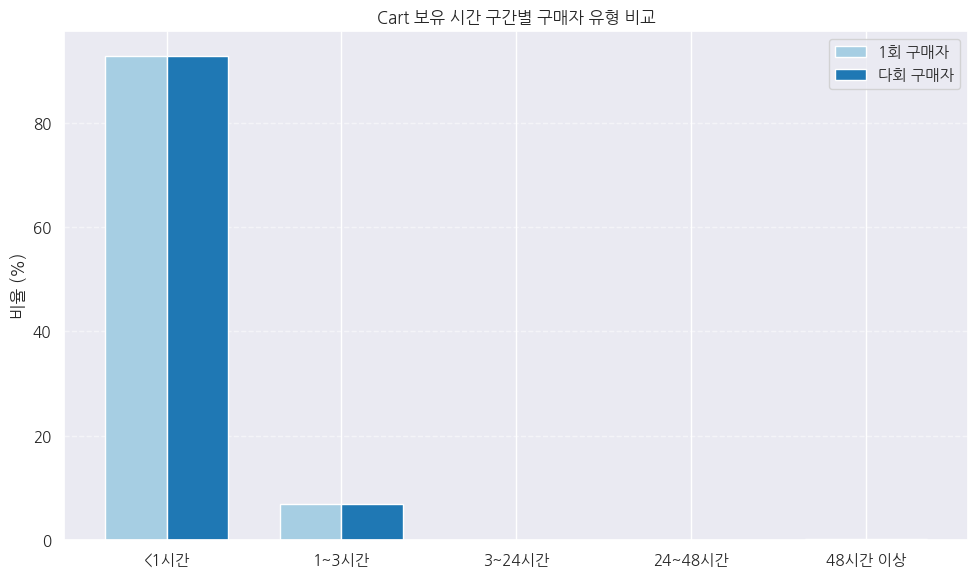

In [ ]:
# 구간 정의
bins = [0, 1, 3, 24, 48, 9999]
labels = ['<1시간', '1~3시간', '3~24시간', '24~48시간', '48시간 이상']

# 카테고리 라벨링
one_time_cut = pd.cut(cart_hold_time_one_time, bins=bins, labels=labels, right=False)
multi_cut = pd.cut(cart_hold_time_multi, bins=bins, labels=labels, right=False)

# 비율 계산
one_time_ratio = one_time_cut.value_counts(normalize=True).sort_index()
multi_ratio = multi_cut.value_counts(normalize=True).sort_index()

# 그룹형 막대그래프
import numpy as np

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, one_time_ratio.values * 100, width, label='1회 구매자', color='#a6cee3')
plt.bar(x + width/2, multi_ratio.values * 100, width, label='다회 구매자', color='#1f78b4')

plt.xticks(x, labels)
plt.ylabel('비율 (%)')
plt.title('Cart 보유 시간 구간별 구매자 유형 비교')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 🔎 평균 cart 보유 시간 1시간 이상 비율 확인

In [ ]:
# 1시간 이상 보유한 경우만 필터링
one_time_over1h = cart_hold_time_one_time[cart_hold_time_one_time >= 1]
multi_over1h = cart_hold_time_multi[cart_hold_time_multi >= 1]

print(f"[1회 구매자] 1시간 이상 보유 비율: {len(one_time_over1h) / len(cart_hold_time_one_time) * 100:.2f}%")
print(f"[다회 구매자] 1시간 이상 보유 비율: {len(multi_over1h) / len(cart_hold_time_multi) * 100:.2f}%")

[1회 구매자] 1시간 이상 보유 비율: 7.10%
[다회 구매자] 1시간 이상 보유 비율: 7.10%


### 🔎 평균 cart 보유 시간 1시간 이상 분포(막대 그래프)

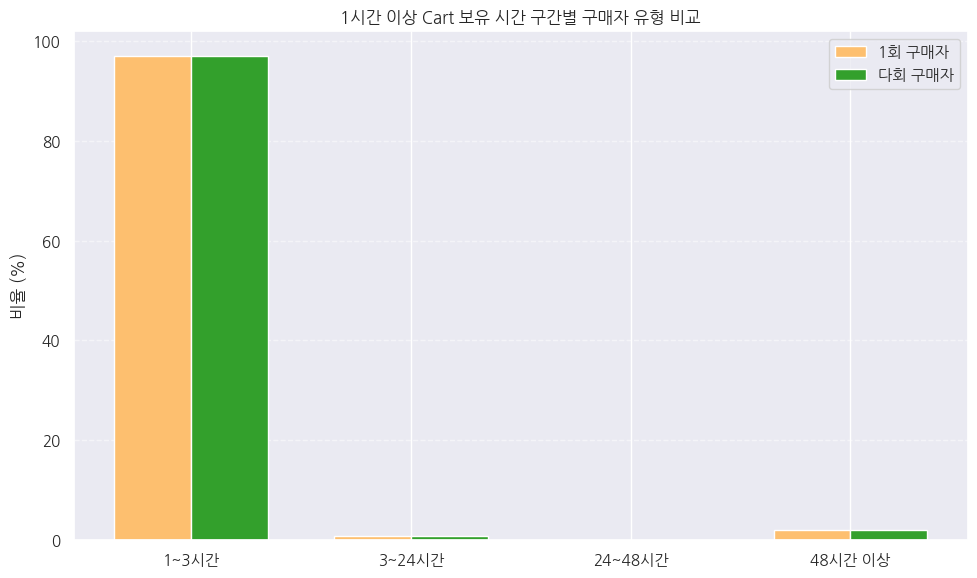

In [ ]:
# 1시간 이상만 다루므로 bins 조정
bins_1hplus = [1, 3, 24, 48, 9999]
labels_1hplus = ['1~3시간', '3~24시간', '24~48시간', '48시간 이상']

# cut
one_time_cut_1hplus = pd.cut(one_time_over1h, bins=bins_1hplus, labels=labels_1hplus, right=False)
multi_cut_1hplus = pd.cut(multi_over1h, bins=bins_1hplus, labels=labels_1hplus, right=False)

# 비율
one_time_ratio_1hplus = one_time_cut_1hplus.value_counts(normalize=True).sort_index()
multi_ratio_1hplus = multi_cut_1hplus.value_counts(normalize=True).sort_index()

x = np.arange(len(labels_1hplus))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, one_time_ratio_1hplus.values * 100, width, label='1회 구매자', color='#fdbf6f')
plt.bar(x + width/2, multi_ratio_1hplus.values * 100, width, label='다회 구매자', color='#33a02c')

plt.xticks(x, labels_1hplus)
plt.ylabel('비율 (%)')
plt.title('1시간 이상 Cart 보유 시간 구간별 구매자 유형 비교')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 🔎 'electronics' 'appliances' 'construction'별 평균 cart 보유 시간 비교

In [ ]:
# 분석 대상 카테고리
target_categories = ['electronics', 'appliances', 'construction']

one_time_target = top_one_df[top_one_df['category_lvl1'].isin(target_categories)].copy()
multi_time_target = top_multi_df[top_multi_df['category_lvl1'].isin(target_categories)].copy()

# Cart 보유 시간 계산 함수
def calculate_cart_hold_hours(df, category_name):
    # 해당 카테고리 필터링
    category_df = df[df['category_lvl1'] == category_name].copy()

    # event_datetime 생성
    category_df['event_datetime'] = category_df['event_date'] + pd.to_timedelta(category_df['event_hour'], unit='h')
    category_df['event_datetime'] = pd.to_datetime(category_df['event_datetime'])

    # 장바구니, 구매 시점 추출
    cart_times = category_df[category_df['event_type'] == 'cart'].groupby('user_id')['event_datetime'].min()
    purchase_times = category_df[category_df['event_type'] == 'purchase'].groupby('user_id')['event_datetime'].min()

    # cart → purchase 연결
    merged = pd.merge(cart_times, purchase_times, on='user_id', suffixes=('_cart', '_purchase'))

    # 보유 시간 계산 (단위: 시간)
    hold_hours = (merged['event_datetime_purchase'] - merged['event_datetime_cart']).dt.total_seconds() / 3600

    return hold_hours

# 카테고리별 평균 Cart 보유 시간 저장
results = {}
for category in target_categories:
    one_time_hold = calculate_cart_hold_hours(one_time_target, category)
    multi_time_hold = calculate_cart_hold_hours(multi_time_target, category)

    results[category] = {
        '1회 구매자 평균': round(one_time_hold.mean(), 2),
        '다회 구매자 평균': round(multi_time_hold.mean(), 2)
    }

# 결과 데이터프레임 생성
cart_hold_summary_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': '카테고리'})

# 결과 출력
print("카테고리별 1회 vs 다회 구매자 평균 Cart 보유 시간 (단위: 시간)")
display(cart_hold_summary_df)

카테고리별 1회 vs 다회 구매자 평균 Cart 보유 시간 (단위: 시간)


,카테고리,1회 구매자 평균,다회 구매자 평균
0,electronics,43.72,9.40
1,appliances,61.14,23.90
2,construction,55.09,64.06


## 📈 비주력상품 EDA

### 💵 1번만 구매

### 🔎 구매 가격 분포

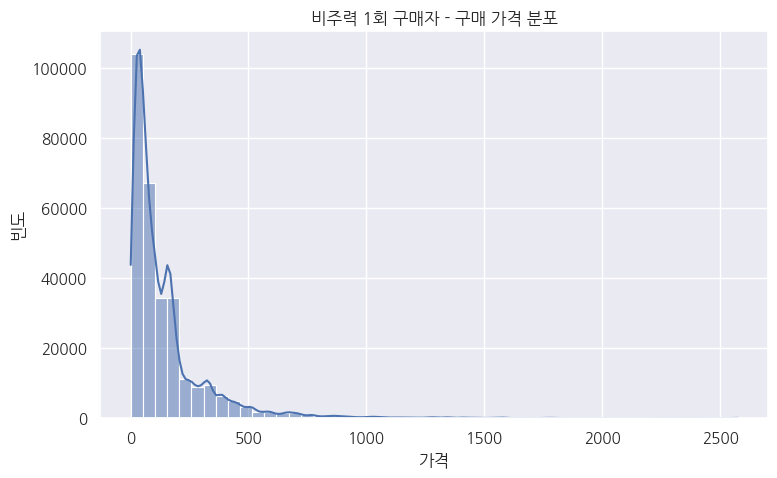

In [ ]:
# 구매 이벤트만 추출
purchase_df = notop_one_df[notop_one_df['event_type'] == 'purchase']

# 가격 분포
plt.figure(figsize=(8, 5))
sns.histplot(purchase_df['price'], bins=50, kde=True)
plt.title('비주력 1회 구매자 - 구매 가격 분포')
plt.xlabel('가격')
plt.ylabel('빈도')
plt.tight_layout()
plt.show()

### 🔎 가격 구간별 전환율

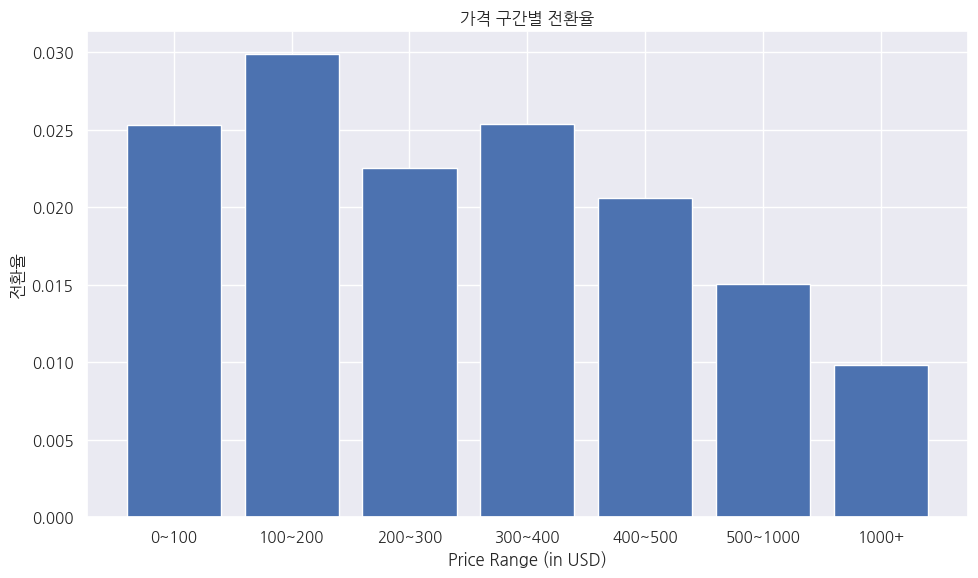

In [ ]:
# 1. 가격 구간 나누기 (10만원 단위, 필요시 조정 가능)
# 올바른 bins와 labels 정의
bins = [0, 100, 200, 300, 400, 500, 1000, float('inf')]  # 8개 → 7개 구간
labels = ['0~100', '100~200', '200~300', '300~400', '400~500', '500~1000', '1000+']  # 7개

# 가격 구간 생성
notop_one_df['price_bin'] = pd.cut(notop_one_df['price'], bins=bins, labels=labels, right=False)


# 2. 구매, 조회 이벤트만 나누기
purchase_df = notop_one_df[notop_one_df['event_type'] == 'purchase']
view_df = notop_one_df[notop_one_df['event_type'] == 'view']

# 3. 가격 구간별 이벤트 수 집계
purchase_stats = purchase_df['price_bin'].value_counts().sort_index().reset_index()
purchase_stats.columns = ['price_bin', 'purchase_count']

view_stats = view_df['price_bin'].value_counts().sort_index().reset_index()
view_stats.columns = ['price_bin', 'view_count']

# 4. 병합 및 전환율 계산
price_group_stats = pd.merge(purchase_stats, view_stats, on='price_bin', how='outer')

# 숫자 컬럼만 골라서 NaN을 0으로 대체
numeric_cols = ['purchase_count', 'view_count']
price_group_stats[numeric_cols] = price_group_stats[numeric_cols].fillna(0)

# 전환율 계산
price_group_stats['conversion_rate'] = price_group_stats['purchase_count'] / price_group_stats['view_count']

# 결과 확인
# print(price_group_stats)

plt.figure(figsize=(10, 6))
plt.bar(price_group_stats['price_bin'].astype(str), price_group_stats['conversion_rate'])
plt.title('가격 구간별 전환율')
plt.xlabel('Price Range (in USD)')
plt.ylabel('전환율')
plt.tight_layout()
plt.show()

### 🔎 카테고리 레벨3별 전환 퍼널 분석(전환율)

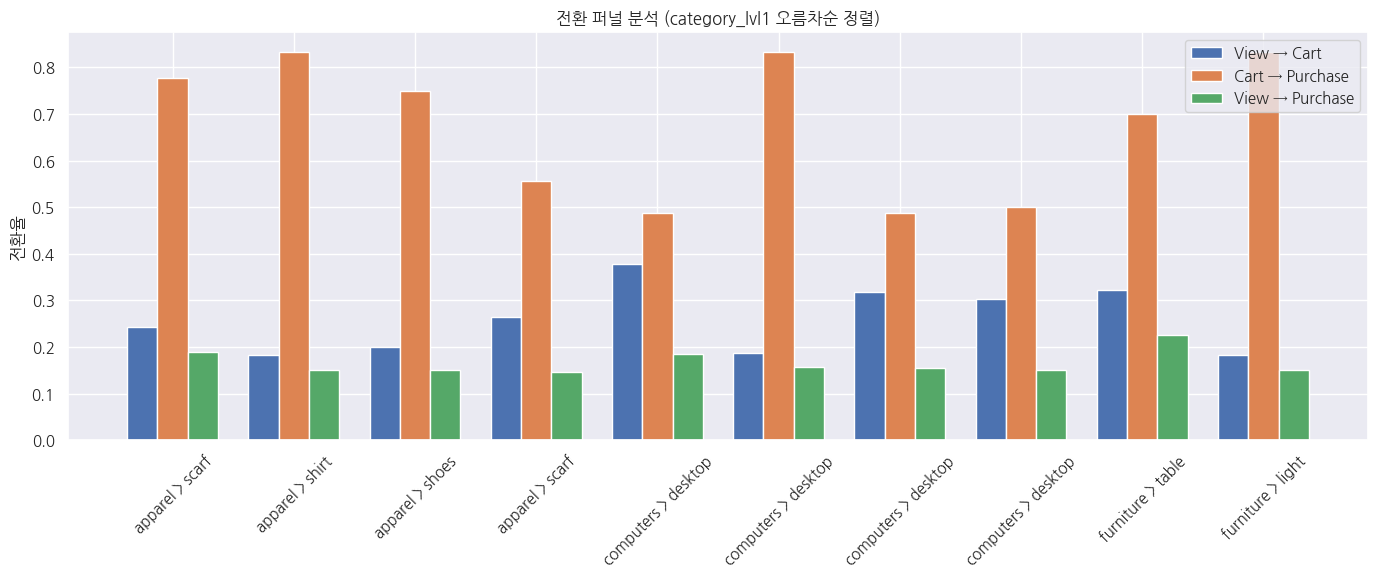

In [ ]:
# 1. 이벤트별 필터링
views = notop_one_df[notop_one_df['event_type'] == 'view']
carts = notop_one_df[notop_one_df['event_type'] == 'cart']
purchases = notop_one_df[notop_one_df['event_type'] == 'purchase']

# 2. 상품별 이벤트 수 집계
view_counts = views.groupby('product_id').size().reset_index(name='view_count')
cart_counts = carts.groupby('product_id').size().reset_index(name='cart_count')
purchase_counts = purchases.groupby('product_id').size().reset_index(name='purchase_count')

# 3. 병합
product_stats = view_counts.merge(cart_counts, on='product_id', how='outer')
product_stats = product_stats.merge(purchase_counts, on='product_id', how='outer')
product_stats.fillna(0, inplace=True)

# 4. 퍼널 전환율 계산
product_stats['view_to_cart_rate'] = product_stats['cart_count'] / product_stats['view_count']
product_stats['cart_to_purchase_rate'] = product_stats['purchase_count'] / product_stats['cart_count']
product_stats['view_to_purchase_rate'] = product_stats['purchase_count'] / product_stats['view_count']

# 5. 상품 정보 결합 (선택)
product_stats = pd.merge(
    product_stats,
    notop_one_df[['product_id', 'category_lvl1', 'category_lvl2', 'category_lvl3']].drop_duplicates(),
    on='product_id', how='left'
)

# 6. 결과 확인 (view 수 기준으로 필터링하여 너무 적은 데이터 제거 가능)
product_stats_filtered = product_stats[product_stats['view_count'] >= 30]
# print(product_stats_filtered[['product_id', 'category_lvl3', 'view_to_cart_rate', 'cart_to_purchase_rate', 'view_to_purchase_rate']].sort_values(by='view_to_purchase_rate', ascending=False).head(10))

## 시각화 ##
# 1. 새로운 라벨 컬럼 생성
top_funnel = product_stats_filtered.sort_values(by='view_to_purchase_rate', ascending=False).head(10)

top_funnel['category_label'] = top_funnel['category_lvl1'] + ' > ' + top_funnel['category_lvl3']

# 2. category_lvl1 기준 오름차순 정렬
top_funnel_sorted = top_funnel.sort_values(by='category_lvl1')

# 3. 시각화
plt.figure(figsize=(14, 6))
bar_width = 0.25
x = range(len(top_funnel_sorted))

plt.bar(x, top_funnel_sorted['view_to_cart_rate'], width=bar_width, label='View → Cart')
plt.bar([p + bar_width for p in x], top_funnel_sorted['cart_to_purchase_rate'], width=bar_width, label='Cart → Purchase')
plt.bar([p + bar_width*2 for p in x], top_funnel_sorted['view_to_purchase_rate'], width=bar_width, label='View → Purchase')

# 정렬된 라벨 적용
plt.xticks([p + bar_width for p in x], top_funnel_sorted['category_label'], rotation=45)
plt.ylabel('전환율')
plt.title('전환 퍼널 분석 (category_lvl1 오름차순 정렬)')
plt.legend()
plt.tight_layout()
plt.show()

### 🔎 카테고리 레벨2, 3별 매출 총합 순위

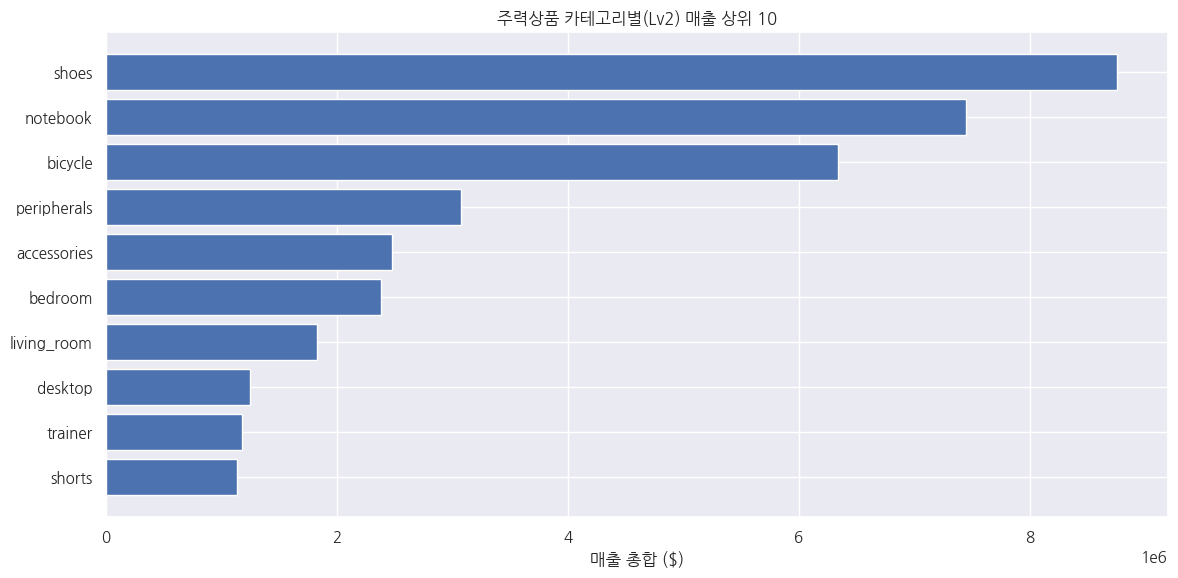

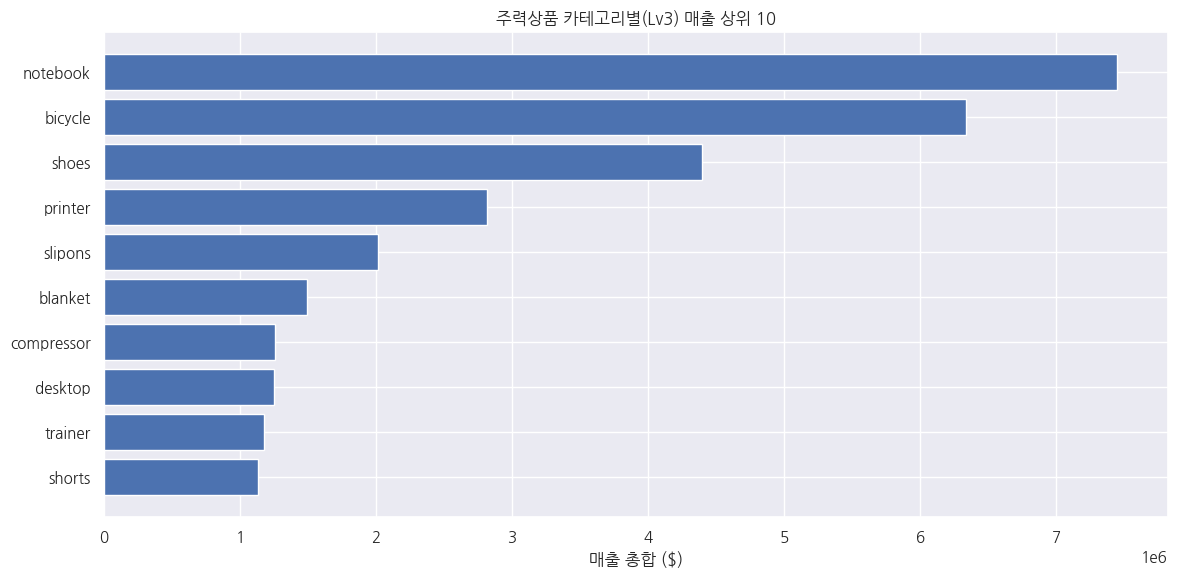

In [ ]:
# 1. 상품별 매출 계산 (price × 건수)
purchase_df = notop_one_df[notop_one_df['event_type'] == 'purchase']
product_revenue = purchase_df.groupby('product_id')['price'].sum().reset_index(name='total_revenue')

# 2. 상품 정보 붙이기 (카테고리 포함)
product_info = notop_one_df[['product_id', 'category_lvl1', 'category_lvl2', 'category_lvl3']].drop_duplicates()
product_revenue = pd.merge(product_revenue, product_info, on='product_id', how='left')

# 3. 매출 총합 상위 10개 상품 출력
top_products = product_revenue.sort_values(by='total_revenue', ascending=False).head(10)
# print(top_products)

# 4. 카테고리별 매출 총합 (category_lvl2 기준)
category_revenue = purchase_df.groupby('category_lvl2')['price'].sum().reset_index(name='total_revenue')
category_revenue = category_revenue.sort_values(by='total_revenue', ascending=False).head(10)

# 5. 시각화
plt.figure(figsize=(12,6))
plt.barh(category_revenue['category_lvl2'], category_revenue['total_revenue'])
plt.xlabel('매출 총합 ($)')
plt.title('주력상품 카테고리별(Lv2) 매출 상위 10')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 4. 카테고리별 매출 총합 (category_lvl3 기준)
category_revenue = purchase_df.groupby('category_lvl3')['price'].sum().reset_index(name='total_revenue')
category_revenue = category_revenue.sort_values(by='total_revenue', ascending=False).head(10)

# 5. 시각화
plt.figure(figsize=(12,6))
plt.barh(category_revenue['category_lvl3'], category_revenue['total_revenue'])
plt.xlabel('매출 총합 ($)')
plt.title('주력상품 카테고리별(Lv3) 매출 상위 10')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 💸 2번이상 구매

### 🔎 고객 유형 별 레벨 3 상품 구매 건수

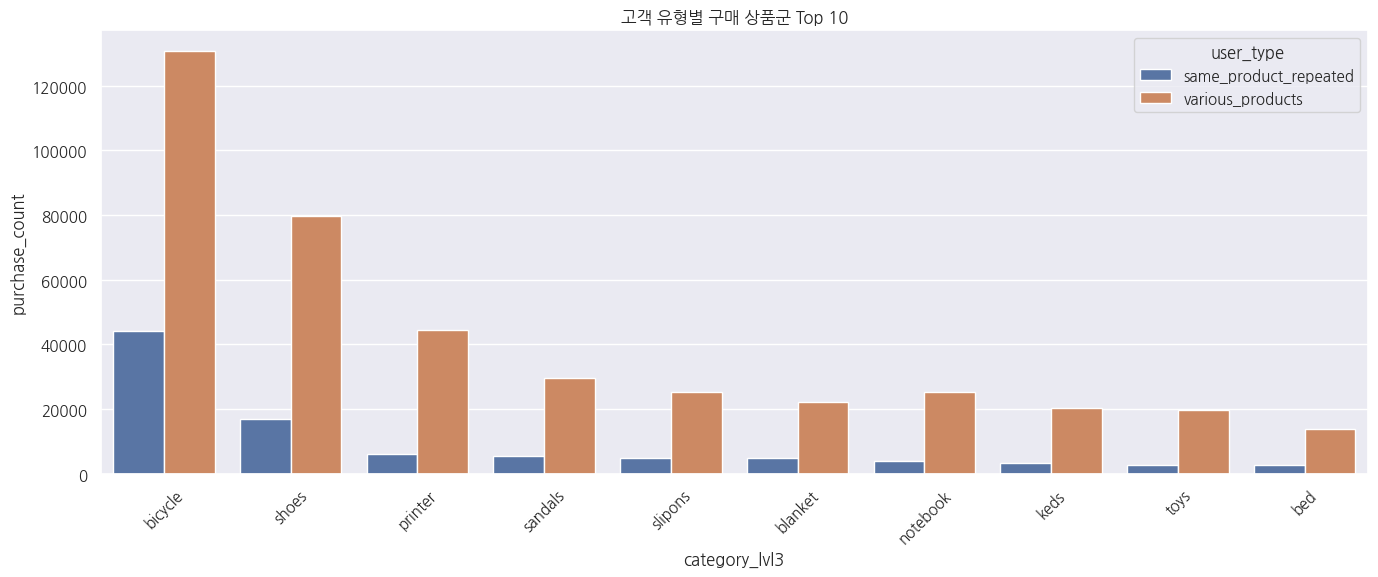

In [ ]:
# 구매 데이터만 필터링
purchase_df = notop_multi_df[notop_multi_df['event_type'] == 'purchase']

# 고객별 총 구매 수
user_total_purchases = purchase_df.groupby('user_id')['product_id'].count().reset_index(name='total_purchases')

# 고객별 고유한 product_id 수
user_unique_products = purchase_df.groupby('user_id')['product_id'].nunique().reset_index(name='unique_products')

# 병합
user_profile = pd.merge(user_total_purchases, user_unique_products, on='user_id')

# 고객 유형 분류
def classify_user(row):
    if row['unique_products'] == 1:
        return 'same_product_repeated'
    else:
        return 'various_products'

user_profile['user_type'] = user_profile.apply(classify_user, axis=1)

# 결과 확인
# print(user_profile['user_type'].value_counts())

# user_type 정보 결합
purchase_df = purchase_df.merge(user_profile[['user_id', 'user_type']], on='user_id', how='left')

# 사용자 유형 + 카테고리 기준으로 집계
user_type_cat = purchase_df.groupby(['user_type', 'category_lvl3']).size().reset_index(name='purchase_count')

# 상위 10개씩 확인
# print(user_type_cat.sort_values(by='purchase_count', ascending=False).groupby('user_type').head(10))

# 상위 10개만 시각화
top_cats = user_type_cat.groupby('user_type').apply(lambda x: x.sort_values(by='purchase_count', ascending=False).head(10)).reset_index(drop=True)

plt.figure(figsize=(14, 6))
sns.barplot(data=top_cats, x='category_lvl3', y='purchase_count', hue='user_type')
plt.title('고객 유형별 구매 상품군 Top 10')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 🔎 가격 구간별 전환율

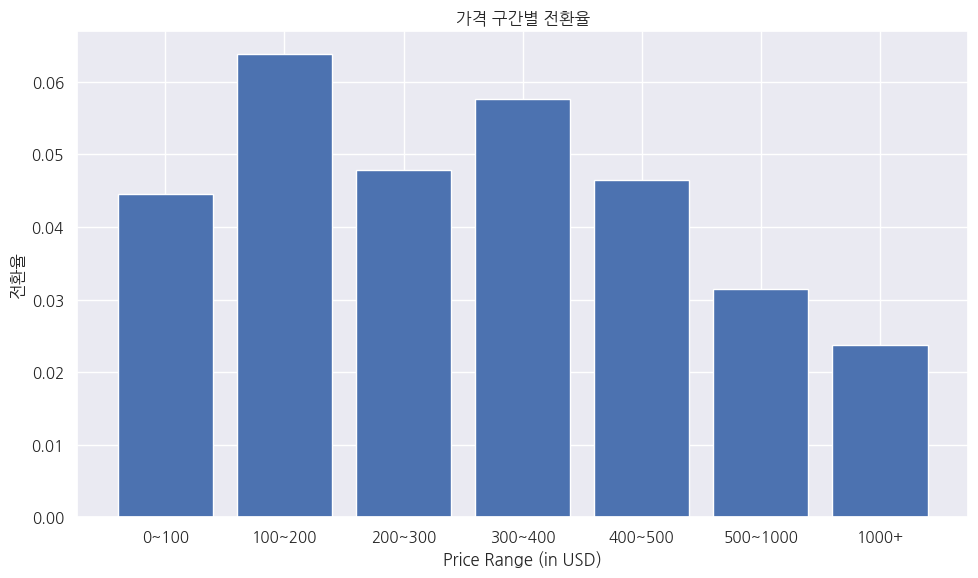

In [ ]:
# 1. 가격 구간 나누기 (10만원 단위, 필요시 조정 가능)
# 올바른 bins와 labels 정의
bins = [0, 100, 200, 300, 400, 500, 1000, float('inf')]  # 8개 → 7개 구간
labels = ['0~100', '100~200', '200~300', '300~400', '400~500', '500~1000', '1000+']  # 7개

# 가격 구간 생성
notop_multi_df['price_bin'] = pd.cut(notop_multi_df['price'], bins=bins, labels=labels, right=False)


# 2. 구매, 조회 이벤트만 나누기
purchase_df = notop_multi_df[notop_multi_df['event_type'] == 'purchase']
view_df = notop_multi_df[notop_multi_df['event_type'] == 'view']

# 3. 가격 구간별 이벤트 수 집계
purchase_stats = purchase_df['price_bin'].value_counts().sort_index().reset_index()
purchase_stats.columns = ['price_bin', 'purchase_count']

view_stats = view_df['price_bin'].value_counts().sort_index().reset_index()
view_stats.columns = ['price_bin', 'view_count']

# 4. 병합 및 전환율 계산
price_group_stats = pd.merge(purchase_stats, view_stats, on='price_bin', how='outer')

# 숫자 컬럼만 골라서 NaN을 0으로 대체
numeric_cols = ['purchase_count', 'view_count']
price_group_stats[numeric_cols] = price_group_stats[numeric_cols].fillna(0)

# 전율 계산
price_group_stats['conversion_rate'] = price_group_stats['purchase_count'] / price_group_stats['view_count']

# 결과 확인
# print(price_group_stats)

plt.figure(figsize=(10, 6))
plt.bar(price_group_stats['price_bin'].astype(str), price_group_stats['conversion_rate'])
plt.title('가격 구간별 전환율')
plt.xlabel('Price Range (in USD)')
plt.ylabel('전환율')
plt.tight_layout()
plt.show()

### 🔎 카테고리 레벨3별 전환 퍼널 분석(전환율)

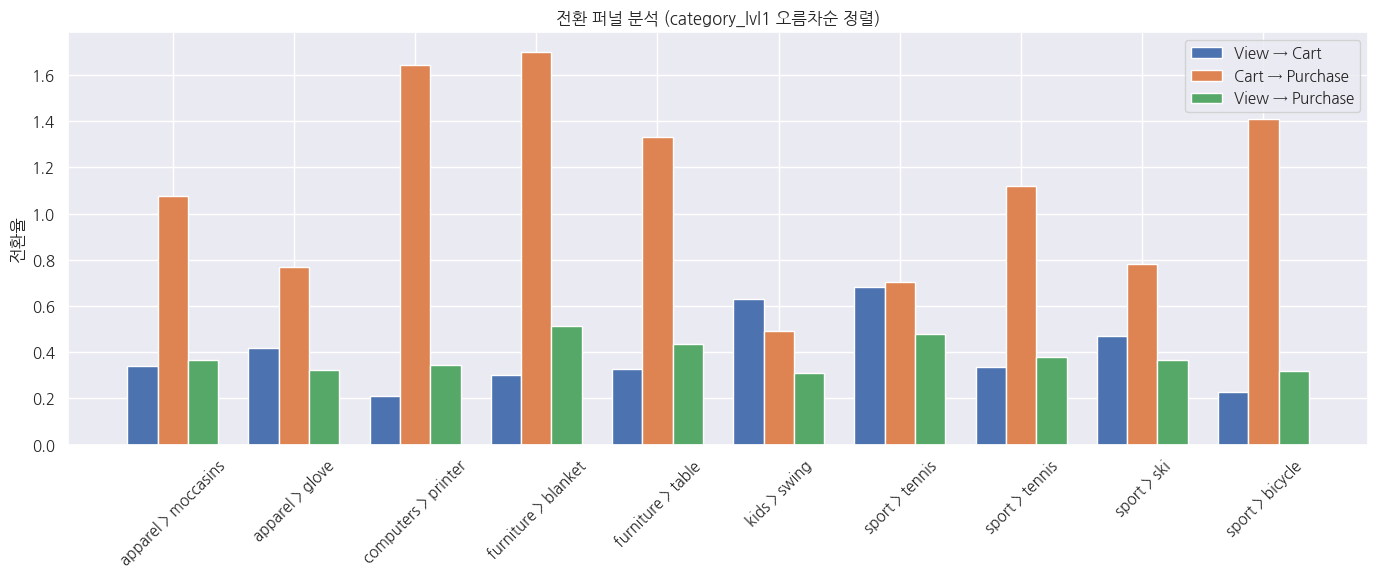

In [ ]:
# 1. 이벤트별 필터링
views = notop_multi_df[notop_multi_df['event_type'] == 'view']
carts = notop_multi_df[notop_multi_df['event_type'] == 'cart']
purchases = notop_multi_df[notop_multi_df['event_type'] == 'purchase']

# 2. 상품별 이벤트 수 집계
view_counts = views.groupby('product_id').size().reset_index(name='view_count')
cart_counts = carts.groupby('product_id').size().reset_index(name='cart_count')
purchase_counts = purchases.groupby('product_id').size().reset_index(name='purchase_count')

# 3. 병합
product_stats = view_counts.merge(cart_counts, on='product_id', how='outer')
product_stats = product_stats.merge(purchase_counts, on='product_id', how='outer')
product_stats.fillna(0, inplace=True)

# 4. 퍼널 전환율 계산
product_stats['view_to_cart_rate'] = product_stats['cart_count'] / product_stats['view_count']
product_stats['cart_to_purchase_rate'] = product_stats['purchase_count'] / product_stats['cart_count']
product_stats['view_to_purchase_rate'] = product_stats['purchase_count'] / product_stats['view_count']

# 5. 상품 정보 결합 (선택)
product_stats = pd.merge(
    product_stats,
    notop_multi_df[['product_id', 'category_lvl1', 'category_lvl2', 'category_lvl3']].drop_duplicates(),
    on='product_id', how='left'
)

# 6. 결과 확인 (view 수 기준으로 필터링하여 너무 적은 데이터 제거 가능)
product_stats_filtered = product_stats[product_stats['view_count'] >= 30]
# print(product_stats_filtered[['product_id', 'category_lvl3', 'view_to_cart_rate', 'cart_to_purchase_rate', 'view_to_purchase_rate']].sort_values(by='view_to_purchase_rate', ascending=False).head(10))

## 시각화 ##
# 1. 새로운 라벨 컬럼 생성
top_funnel = product_stats_filtered.sort_values(by='view_to_purchase_rate', ascending=False).head(10)

top_funnel['category_label'] = top_funnel['category_lvl1'] + ' > ' + top_funnel['category_lvl3']

# 2. category_lvl1 기준 오름차순 정렬
top_funnel_sorted = top_funnel.sort_values(by='category_lvl1')

# 3. 시각화
plt.figure(figsize=(14, 6))
bar_width = 0.25
x = range(len(top_funnel_sorted))

plt.bar(x, top_funnel_sorted['view_to_cart_rate'], width=bar_width, label='View → Cart')
plt.bar([p + bar_width for p in x], top_funnel_sorted['cart_to_purchase_rate'], width=bar_width, label='Cart → Purchase')
plt.bar([p + bar_width*2 for p in x], top_funnel_sorted['view_to_purchase_rate'], width=bar_width, label='View → Purchase')

# 정렬된 라벨 적용
plt.xticks([p + bar_width for p in x], top_funnel_sorted['category_label'], rotation=45)
plt.ylabel('전환율')
plt.title('전환 퍼널 분석 (category_lvl1 오름차순 정렬)')
plt.legend()
plt.tight_layout()
plt.show()

### 🔎 고객 수익성 상위 카테고리1

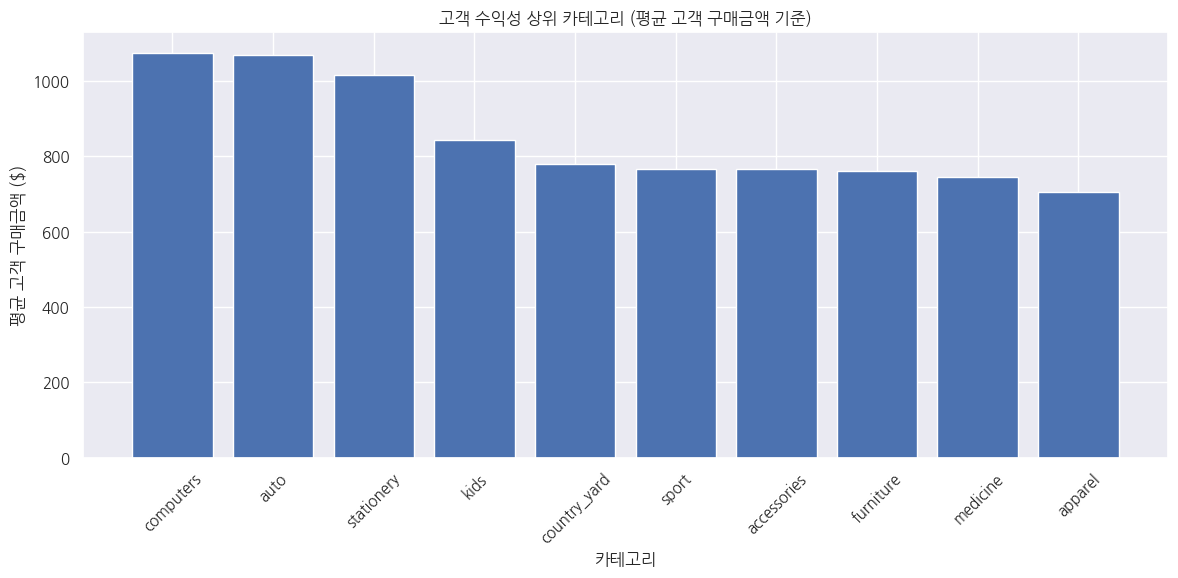

In [ ]:
# 유저별 전체 구매금액
user_value = purchase_df.groupby('user_id')['price'].sum().reset_index()
user_value.columns = ['user_id', 'total_spent']

# 카테고리별 평균 고객 구매금액 계산
avg_value_cat = purchase_df.groupby('category_lvl1')['user_id'].apply(
    lambda x: user_value[user_value['user_id'].isin(x)]['total_spent'].mean()
).reset_index(name='avg_user_value')

# 상위 카테고리 10개 시각화
top_value_cat = avg_value_cat.sort_values('avg_user_value', ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.bar(top_value_cat['category_lvl1'].astype(str), top_value_cat['avg_user_value'])
plt.title('고객 수익성 상위 카테고리 (평균 고객 구매금액 기준)')
plt.xlabel('카테고리')
plt.ylabel('평균 고객 구매금액 ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 🔎 카테고리 레벨2, 3별 매출 총합 순위

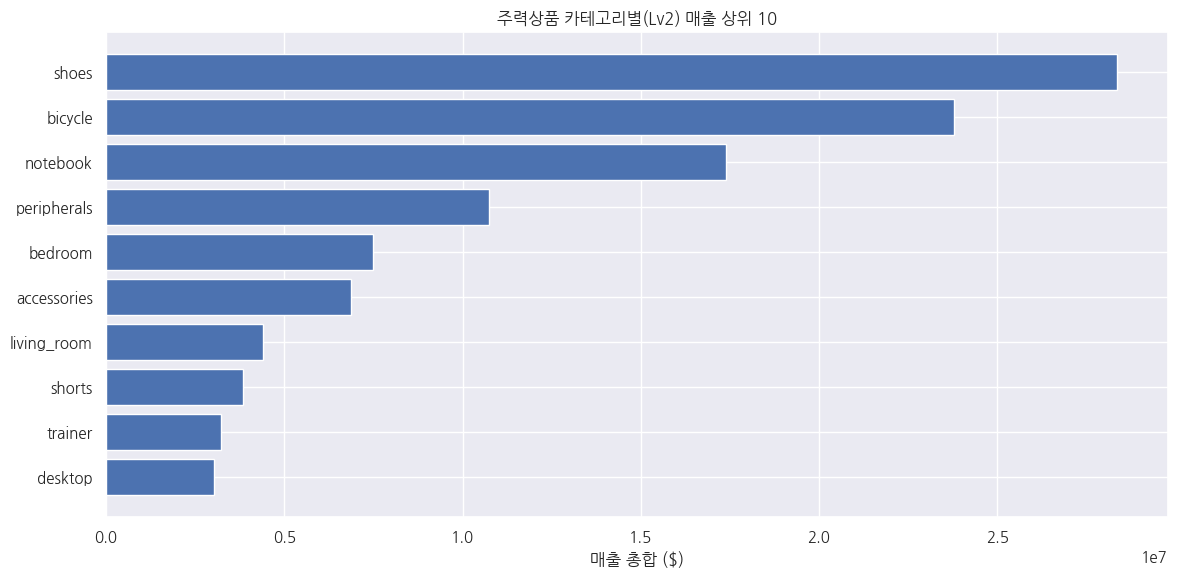

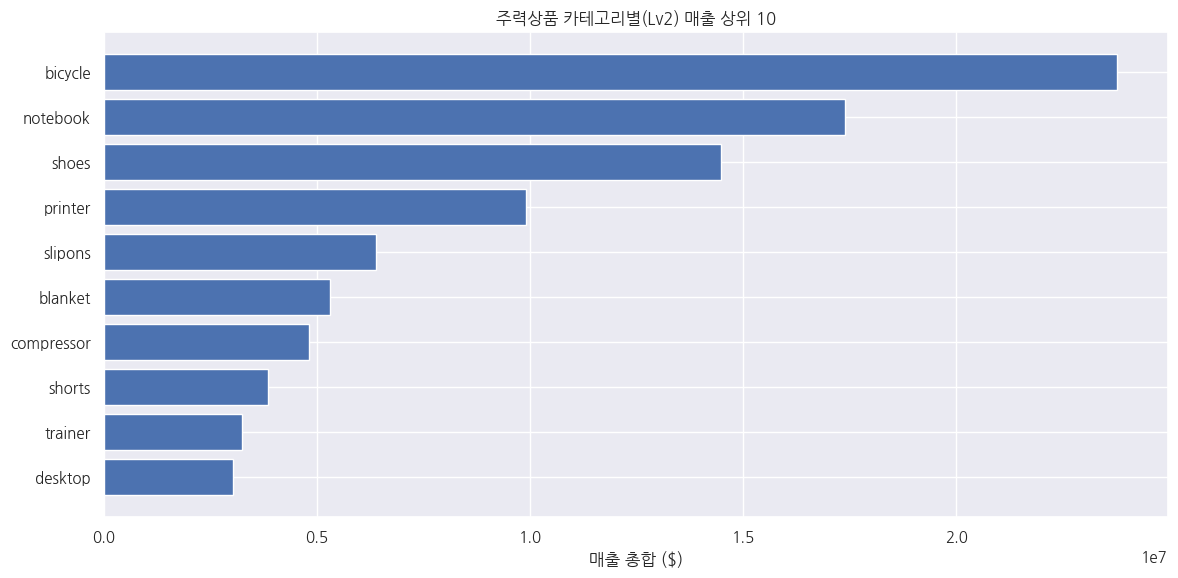

In [ ]:
# 1. 상품별 매출 계산 (price × 건수)
purchase_df = notop_multi_df[notop_multi_df['event_type'] == 'purchase']
product_revenue = purchase_df.groupby('product_id')['price'].sum().reset_index(name='total_revenue')

# 2. 상품 정보 붙이기 (카테고리 포함)
product_info = notop_multi_df[['product_id', 'category_lvl1', 'category_lvl2', 'category_lvl3']].drop_duplicates()
product_revenue = pd.merge(product_revenue, product_info, on='product_id', how='left')

# 3. 매출 총합 상위 10개 상품 출력
top_products = product_revenue.sort_values(by='total_revenue', ascending=False).head(10)
# print(top_products)

## 시각화 ##
# 4. 카테고리별 매출 총합 (category_lvl2 기준)
category_revenue = purchase_df.groupby('category_lvl2')['price'].sum().reset_index(name='total_revenue')
category_revenue = category_revenue.sort_values(by='total_revenue', ascending=False).head(10)

# 5. 시각화
plt.figure(figsize=(12,6))
plt.barh(category_revenue['category_lvl2'], category_revenue['total_revenue'])
plt.xlabel('매출 총합 ($)')
plt.title('주력상품 카테고리별(Lv2) 매출 상위 10')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 4. 카테고리별 매출 총합 (category_lvl3 기준)
category_revenue = purchase_df.groupby('category_lvl3')['price'].sum().reset_index(name='total_revenue')
category_revenue = category_revenue.sort_values(by='total_revenue', ascending=False).head(10)

# 5. 시각화
plt.figure(figsize=(12,6))
plt.barh(category_revenue['category_lvl3'], category_revenue['total_revenue'])
plt.xlabel('매출 총합 ($)')
plt.title('주력상품 카테고리별(Lv2) 매출 상위 10')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### 🔎 카테고리 레벨1 별 평균 재구매 간격(일)

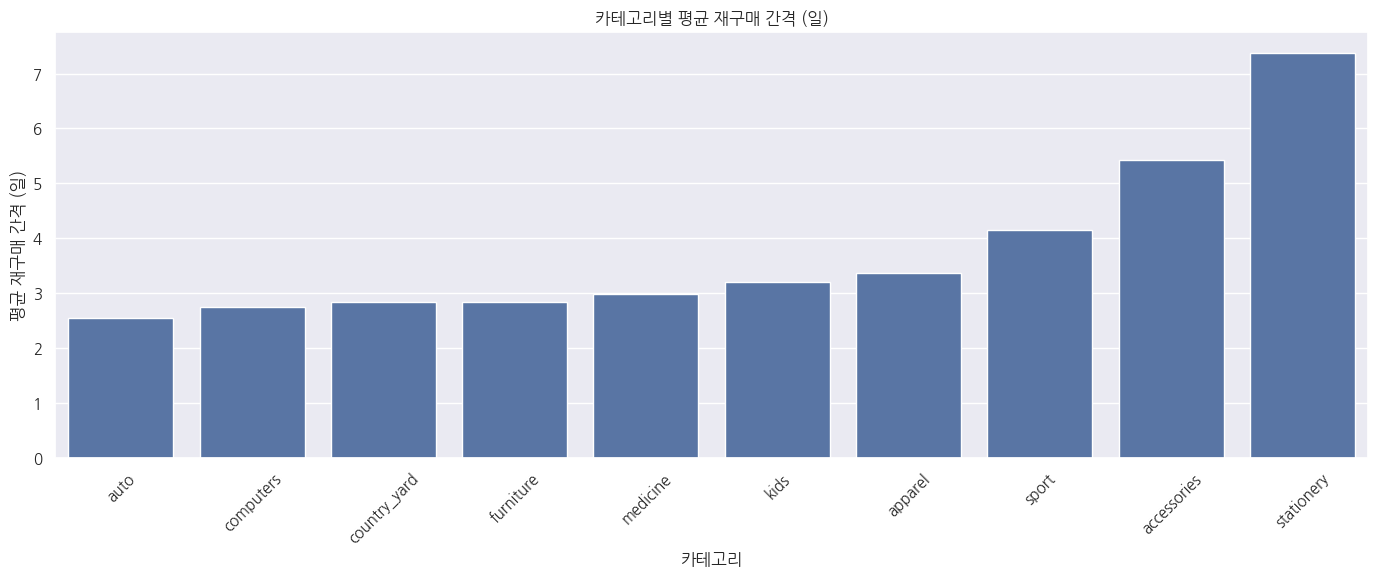

In [ ]:
# 1. 날짜 변환
notop_multi_df['event_date'] = pd.to_datetime(notop_multi_df['event_date'])

# 2. 구매 이벤트 필터링
purchase_df = notop_multi_df[notop_multi_df['event_type'] == 'purchase'].copy()

# 3. 구매 이력 정렬 및 간격 계산
purchase_sorted = purchase_df.sort_values(by=['user_id', 'product_id', 'event_date'])
purchase_sorted['days_diff'] = purchase_sorted.groupby(['user_id', 'product_id'])['event_date'].diff().dt.days

# 4. 상품 기준 평균 재구매 간격
product_days = purchase_sorted.groupby('product_id')['days_diff'].mean().reset_index()
product_days.columns = ['product_id', 'avg_repurchase_gap']

# 5. 카테고리 기준 재구매 간격 계산
repeat_df = purchase_sorted[purchase_sorted['days_diff'].notnull()]  # 재구매가 일어난 경우만
category_repeat_interval = repeat_df.groupby('category_lvl1')['days_diff'].mean().reset_index()
category_repeat_interval.columns = ['category_lvl1', 'avg_days_between_purchase']

# 6. 시각화
plt.figure(figsize=(14, 6))
sns.barplot(data=category_repeat_interval.sort_values('avg_days_between_purchase'),
            x='category_lvl1', y='avg_days_between_purchase')
plt.xticks(rotation=45)
plt.title('카테고리별 평균 재구매 간격 (일)')
plt.xlabel('카테고리')
plt.ylabel('평균 재구매 간격 (일)')
plt.tight_layout()
plt.show()

### 🔎 첫 구매 행동 패턴 분석(장바구니 보유 시간, 즉시 구매자 비율 확인)

In [ ]:
# 첫 구매 이전 cart -> purchase 시간 계산
# 1. event_datetime 컬럼 생성
notop_multi_df['event_datetime'] = notop_multi_df['event_date'] + pd.to_timedelta(notop_multi_df['event_hour'], unit='h')
notop_multi_df['event_datetime'] = pd.to_datetime(notop_multi_df['event_datetime'])

# 2. 각 유저의 첫 purchase 시간 구하기
first_purchase_time = notop_multi_df[notop_multi_df['event_type'] == 'purchase'] \
                        .groupby('user_id')['event_datetime'].min() \
                        .rename('first_purchase_time')

# 3. 첫 구매 이전의 행동만 필터링
notop_multi_df = notop_multi_df.join(first_purchase_time, on='user_id')
notop_multi_df_first_purchase = notop_multi_df[notop_multi_df['event_datetime'] <= notop_multi_df['first_purchase_time']].copy()

# 4. 해당 구간 내에서 cart/purchase 시점 추출
df_cart = notop_multi_df_first_purchase[notop_multi_df_first_purchase['event_type'] == 'cart']
df_purchase = notop_multi_df_first_purchase[notop_multi_df_first_purchase['event_type'] == 'purchase']

cart_times = df_cart.groupby('user_id')['event_datetime'].min()
purchase_times = df_purchase.groupby('user_id')['event_datetime'].min()

# 5. 공통 user_id 기준 병합 및 시간 차 계산 (단위: 시간)
merged = pd.merge(cart_times, purchase_times, on='user_id', suffixes=('_cart', '_purchase'))
cart_hold_time_first_purchase = (merged['event_datetime_purchase'] - merged['event_datetime_cart']).dt.total_seconds() / 3600


In [ ]:
print("평균 Cart 보유 시간 (시간):", cart_hold_time_first_purchase.mean())

평균 Cart 보유 시간 (시간): 119.36585418301848


In [ ]:
# 즉시 구매자 비율 확인
instant_buyers_ratio = (cart_hold_time_first_purchase == 0).mean() * 100
print(f"즉시 구매자 비율: {instant_buyers_ratio:.2f}%")

즉시 구매자 비율: 77.52%


## 🧾 통합

### 🔎 카테고리별 구매율(1회 vs 2회이상 구매고객, 막대)

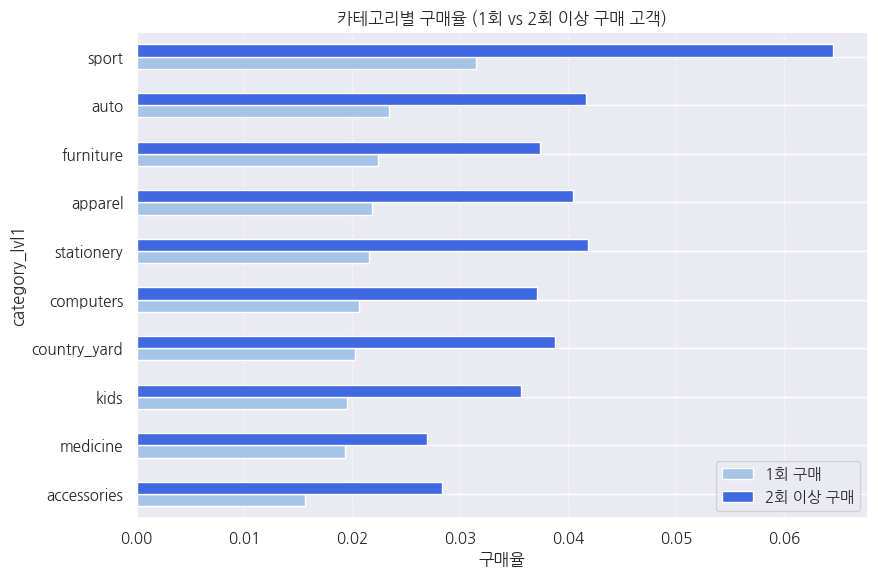

In [ ]:
# Step 1: 구매 횟수 기반 고객 분리
purchase_counts = df_other[df_other['event_type'] == 'purchase'].groupby('user_id').size()
one_time_buyers = purchase_counts[purchase_counts == 1].index
multi_buyers = purchase_counts[purchase_counts >= 2].index

# Step 2: 1회 고객 카테고리별 구매율
category_rate_one = (
    df_other[df_other['user_id'].isin(one_time_buyers)]
    .groupby('category_lvl1')['event_type']
    .apply(lambda x: (x == 'purchase').mean())
    .rename('1회 구매')
)

# Step 3: 2회 이상 고객 카테고리별 구매율
category_rate_multi = (
    df_other[df_other['user_id'].isin(multi_buyers)]
    .groupby('category_lvl1')['event_type']
    .apply(lambda x: (x == 'purchase').mean())
    .rename('2회 이상 구매')
)

# Step 4: 병합
category_rate_compare = pd.concat([category_rate_one, category_rate_multi], axis=1).fillna(0)

# Step 5: 시각화
category_rate_compare.sort_values('1회 구매', ascending=True).plot(
    kind='barh', figsize=(9, 6), color=['#a6c4e8', '#4068e0']
)
plt.title('카테고리별 구매율 (1회 vs 2회 이상 구매 고객)')
plt.xlabel('구매율')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 🔎 카테고리별 view수 비교(1회 vs 2회이상 구매 고객, 막대)

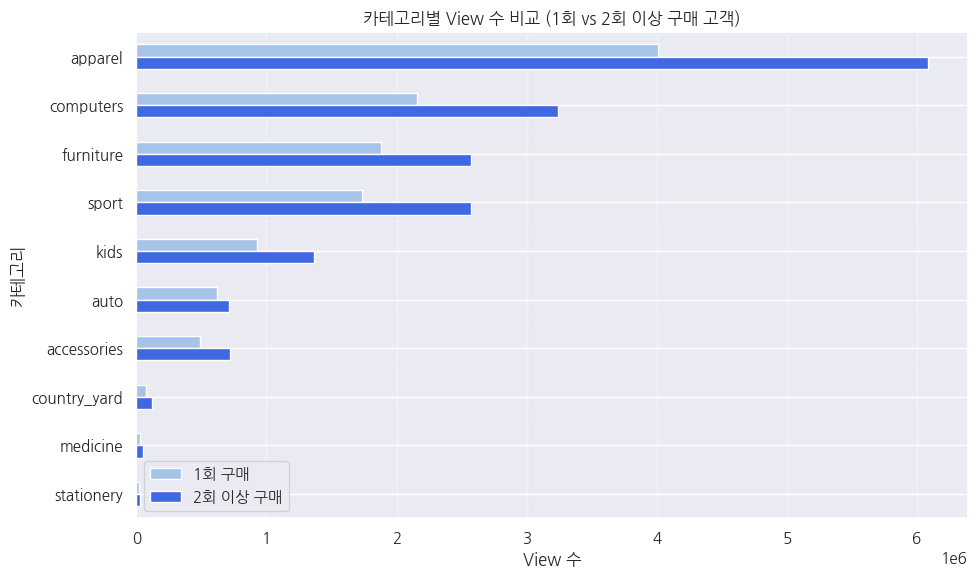

In [ ]:
# 1. 구매 횟수 계산
purchase_counts = df_other[df_other['event_type'] == 'purchase'].groupby('user_id').size()

# 2. 그룹 분류
one_time_buyers = purchase_counts[purchase_counts == 1].index
multi_buyers    = purchase_counts[purchase_counts >= 2].index

# 1회 구매 고객 view 수
view_counts_one = (
    df_other[(df_other['event_type'] == 'view') & (df_other['user_id'].isin(one_time_buyers))]
    .groupby('category_lvl1')['user_id']
    .count()
)

# 2회 이상 구매 고객 view 수
view_counts_multi = (
    df_other[(df_other['event_type'] == 'view') & (df_other['user_id'].isin(multi_buyers))]
    .groupby('category_lvl1')['user_id']
    .count()
)

# 결합 (빈 카테고리 채우기 위해 outer join)
view_compare = pd.concat(
    [view_counts_one.rename('1회 구매'), view_counts_multi.rename('2회 이상 구매')],
    axis=1
).fillna(0).astype(int).sort_values('1회 구매', ascending=False)

# 막대그래프 그리기
view_compare.plot(kind='barh', figsize=(10, 6), color=['#a6c4e8', '#4068e0'])
plt.title('카테고리별 View 수 비교 (1회 vs 2회 이상 구매 고객)')
plt.xlabel('View 수')
plt.ylabel('카테고리')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 🔎 2회 이상 구매자의 첫->두 번째 구매에서 카테고리 변경 비율, 경로

2회 이상 구매자의 첫→두번째 구매에서 카테고리 변경 비율: 0.313

상세 분포:
category_changed
False    141218
True      64282
Name: count, dtype: int64


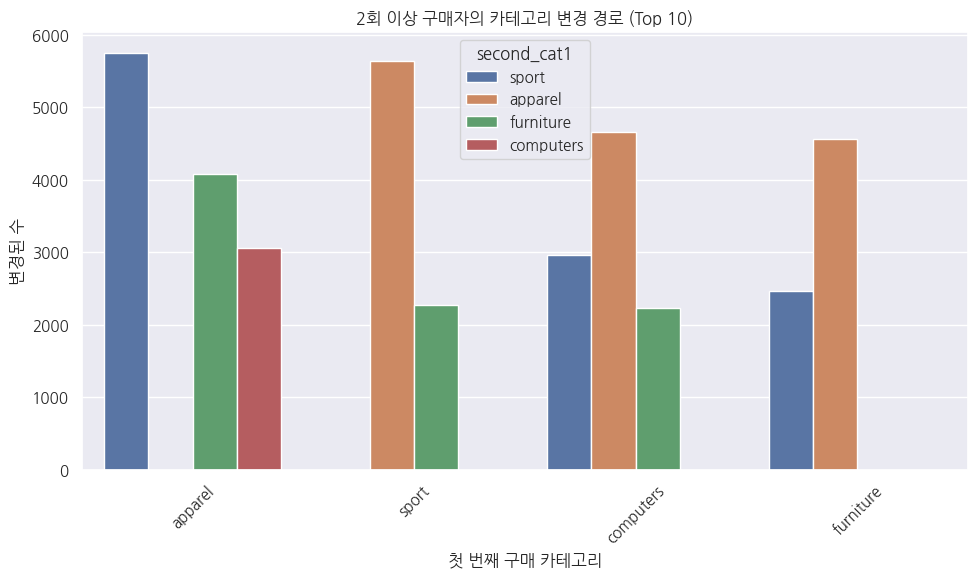

In [ ]:
# 구매 이벤트만 필터링
multi_purchase = notop_multi_df[notop_multi_df['event_type'] == 'purchase'].copy()

# 날짜 정렬
multi_purchase['event_date'] = pd.to_datetime(multi_purchase['event_date'])
multi_purchase = multi_purchase.sort_values(by=['user_id', 'event_date'])

# 유저별 구매 순서 부여
multi_purchase['purchase_order'] = multi_purchase.groupby('user_id').cumcount() + 1

# 첫 번째, 두 번째 구매만 추출
first_second = multi_purchase[multi_purchase['purchase_order'] <= 2]

# 첫/두 번째 구매를 하나의 행에 피벗
pivoted = first_second.pivot(index='user_id', columns='purchase_order', values='category_lvl1')
pivoted.columns = ['first_cat1', 'second_cat1']
pivoted = pivoted.dropna()

# 변경 여부 판단
pivoted['category_changed'] = pivoted['first_cat1'] != pivoted['second_cat1']

# 통계 요약
change_rate = pivoted['category_changed'].mean()
change_counts = pivoted['category_changed'].value_counts()

print("2회 이상 구매자의 첫→두번째 구매에서 카테고리 변경 비율:", round(change_rate, 3))
print("\n상세 분포:")
print(change_counts)

# 변경된 경우만 추출
changed_cases = pivoted[pivoted['category_changed']]

# 변화 경로 집계
change_paths = changed_cases.groupby(['first_cat1', 'second_cat1']).size().reset_index(name='count')
change_paths = change_paths.sort_values('count', ascending=False)

# 상위 몇 개만 시각화
top_paths = change_paths.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_paths, y='count', x='first_cat1', hue='second_cat1')
plt.title('2회 이상 구매자의 카테고리 변경 경로 (Top 10)')
plt.xlabel('첫 번째 구매 카테고리')
plt.ylabel('변경된 수')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 🔎 2회 이상 구매자의 카테고리 조합

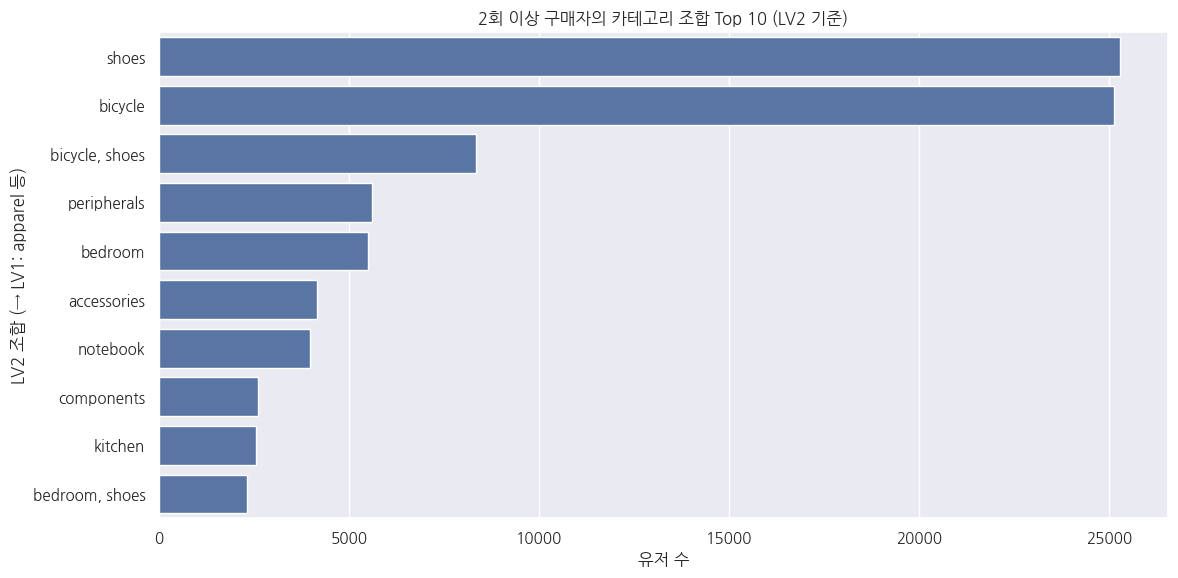

,category_combination,user_count,category_lvl1
0,shoes,25276,apparel
1,bicycle,25128,sport
2,"bicycle, shoes",8341,"apparel, sport"
3,peripherals,5621,computers
4,bedroom,5507,furniture
5,accessories,4179,auto
6,notebook,3984,computers
7,components,2608,computers
8,kitchen,2561,furniture
9,"bedroom, shoes",2338,"apparel, furniture"


In [ ]:
# 1. 구매 이벤트 필터링
multi_purchase = notop_multi_df[notop_multi_df['event_type'] == 'purchase']

# 2. category_lvl2 → category_lvl1 매핑 테이블 생성
lvl2_lvl1_map = multi_purchase[['category_lvl2', 'category_lvl1']].drop_duplicates()

# 3. 유저별 구매한 category_lvl2 조합 생성
cat_combo = multi_purchase.groupby('user_id')['category_lvl2'].apply(lambda x: tuple(sorted(set(x))))
cat_combo = cat_combo.value_counts().head(10).reset_index()
cat_combo.columns = ['category_combination', 'user_count']

# 4. 각 조합에 포함된 category_lvl1 정보 추가
def map_to_lvl1(combo):
    lvl1_set = lvl2_lvl1_map[lvl2_lvl1_map['category_lvl2'].isin(combo)]['category_lvl1'].unique()
    return ', '.join(sorted(set(lvl1_set)))

cat_combo['category_lvl1'] = cat_combo['category_combination'].apply(map_to_lvl1)

# print(cat_combo)

## 시각화 ##
# 5. 튜플을 문자열로 변환 (시각화를 위해)
cat_combo['category_combination'] = cat_combo['category_combination'].apply(lambda x: ', '.join(x))

# 6. 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=cat_combo, y='category_combination', x='user_count')
plt.title('2회 이상 구매자의 카테고리 조합 Top 10 (LV2 기준)')
plt.xlabel('유저 수')
plt.ylabel('LV2 조합 (→ LV1: ' + cat_combo['category_lvl1'].iloc[0] + ' 등)')
plt.tight_layout()
plt.show()

# 결과 확인
display(cat_combo[['category_combination', 'user_count', 'category_lvl1']])

### 🔎 재구매율 낮은 카테고리 2

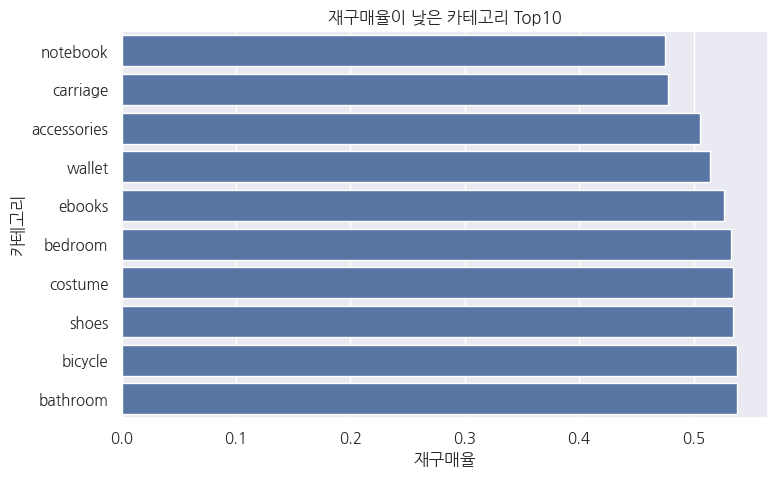

In [ ]:
# 전체 유저 대비 재구매 유저 비율
total_users = notop_one_df[notop_one_df['event_type'] == 'purchase'].groupby('category_lvl2')['user_id'].nunique()
repeat_users = notop_multi_df[notop_multi_df['event_type'] == 'purchase'].groupby('category_lvl2')['user_id'].nunique()

repurchase_rate = (repeat_users / (total_users + repeat_users)).reset_index()
repurchase_rate.columns = ['category_lvl2', 'repurchase_rate']

# 하위 10개 카테고리 시각화
bottom_10 = repurchase_rate.sort_values(by='repurchase_rate').head(10)

plt.figure(figsize=(8,5))
sns.barplot(data=bottom_10, x='repurchase_rate', y='category_lvl2')
plt.title('재구매율이 낮은 카테고리 Top10')
plt.xlabel('재구매율')
plt.ylabel('카테고리')
plt.tight_layout()
plt.show()

### 🔎 평균 cart 보유 시간 비교(수치 확인)

In [ ]:
df = notop_one_df  # 1회 구매자용 전체 데이터

# 1. event_datetime 생성 (vectorized 방식)
df['event_datetime'] = pd.to_datetime(df['event_date']) + pd.to_timedelta(df['event_hour'], unit='h')

# 2. cart & purchase 이벤트 필터링
df_cart = df[df['event_type'] == 'cart']
df_purchase = df[df['event_type'] == 'purchase']

# 3. 세션별 가장 빠른 cart/purchase 시간 추출
cart_times = df_cart.groupby('user_session')['event_datetime'].min().to_frame(name='cart_time')
purchase_times = df_purchase.groupby('user_session')['event_datetime'].min().to_frame(name='purchase_time')

# 4. 공통 세션만 남기고 merge
merged = pd.merge(cart_times, purchase_times, left_index=True, right_index=True)

# 5. 시간차 계산
cart_hold_time = (merged['purchase_time'] - merged['cart_time']).dt.total_seconds() / 3600

# 6. 음수 제거 (올바른 순서만 필터링)
cart_hold_time = cart_hold_time[cart_hold_time >= 0]

# 7. 결과 출력
print(f"[1회 구매자] 평균 Cart 보유 시간 (시간): {cart_hold_time.mean():.2f}")

[1회 구매자] 평균 Cart 보유 시간 (시간): 1.42


In [ ]:
cart_hold_time_one_time = cart_hold_time #1회 구매자

In [ ]:
df = notop_multi_df  # 다회 구매자용 전체 데이터

# 1. event_datetime 생성 (vectorized 방식)
df['event_datetime'] = pd.to_datetime(df['event_date']) + pd.to_timedelta(df['event_hour'], unit='h')

# 2. cart & purchase 이벤트 필터링
df_cart = df[df['event_type'] == 'cart']
df_purchase = df[df['event_type'] == 'purchase']

# 3. 세션별 가장 빠른 cart/purchase 시간 추출
cart_times = df_cart.groupby('user_session')['event_datetime'].min().to_frame(name='cart_time')
purchase_times = df_purchase.groupby('user_session')['event_datetime'].min().to_frame(name='purchase_time')

# 4. 공통 세션만 남기고 merge
merged = pd.merge(cart_times, purchase_times, left_index=True, right_index=True)

# 5. 시간차 계산
cart_hold_time = (merged['purchase_time'] - merged['cart_time']).dt.total_seconds() / 3600

# 6. 음수 제거 (올바른 순서만 필터링)
cart_hold_time = cart_hold_time[cart_hold_time >= 0]

# 7. 결과 출력
print(f"[다회 구매자] 평균 Cart 보유 시간 (시간): {cart_hold_time.mean():.2f}")

[다회 구매자] 평균 Cart 보유 시간 (시간): 0.80


In [ ]:
cart_hold_time_multi = cart_hold_time # 다회 구매자

### 🔎 평균 cart 보유 시간 비교(막대 그래프)

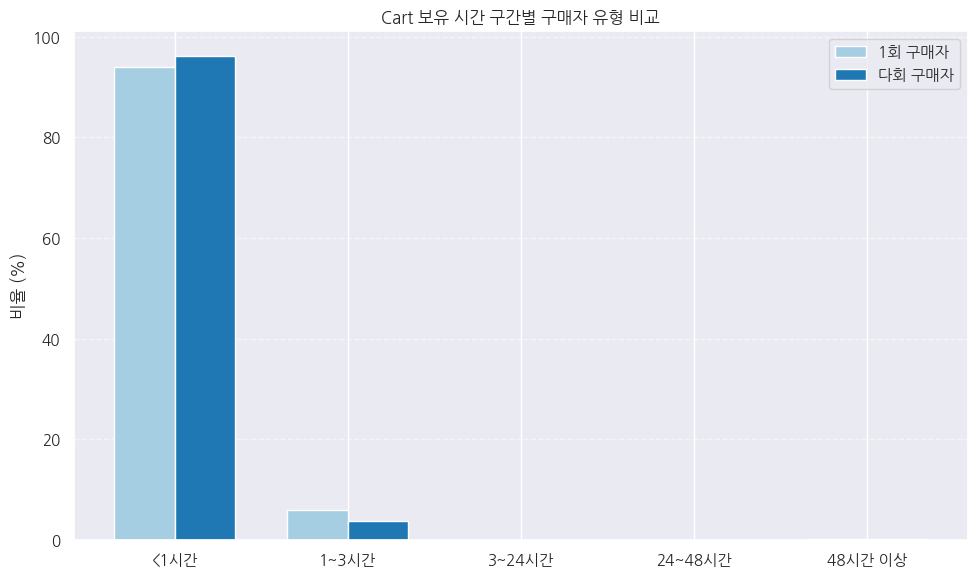

In [ ]:
# 구간 정의
bins = [0, 1, 3, 24, 48, 9999]
labels = ['<1시간', '1~3시간', '3~24시간', '24~48시간', '48시간 이상']

# 카테고리 라벨링
one_time_cut = pd.cut(cart_hold_time_one_time, bins=bins, labels=labels, right=False)
multi_cut = pd.cut(cart_hold_time_multi, bins=bins, labels=labels, right=False)

# 비율 계산
one_time_ratio = one_time_cut.value_counts(normalize=True).sort_index()
multi_ratio = multi_cut.value_counts(normalize=True).sort_index()

# 그룹형 막대그래프
import numpy as np

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, one_time_ratio.values * 100, width, label='1회 구매자', color='#a6cee3')
plt.bar(x + width/2, multi_ratio.values * 100, width, label='다회 구매자', color='#1f78b4')

plt.xticks(x, labels)
plt.ylabel('비율 (%)')
plt.title('Cart 보유 시간 구간별 구매자 유형 비교')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 🔎 평균 cart 보유 시간 1시간 이상 비율 확인

In [ ]:
# 1시간 이상 보유한 경우만 필터링
one_time_over1h = cart_hold_time_one_time[cart_hold_time_one_time >= 1]
multi_over1h = cart_hold_time_multi[cart_hold_time_multi >= 1]

print(f"[1회 구매자] 1시간 이상 보유 비율: {len(one_time_over1h) / len(cart_hold_time_one_time) * 100:.2f}%")
print(f"[다회 구매자] 1시간 이상 보유 비율: {len(multi_over1h) / len(cart_hold_time_multi) * 100:.2f}%")

[1회 구매자] 1시간 이상 보유 비율: 5.98%
[다회 구매자] 1시간 이상 보유 비율: 3.73%


### 🔎 평균 cart 보유 시간 1시간 이상 분포(막대 그래프)

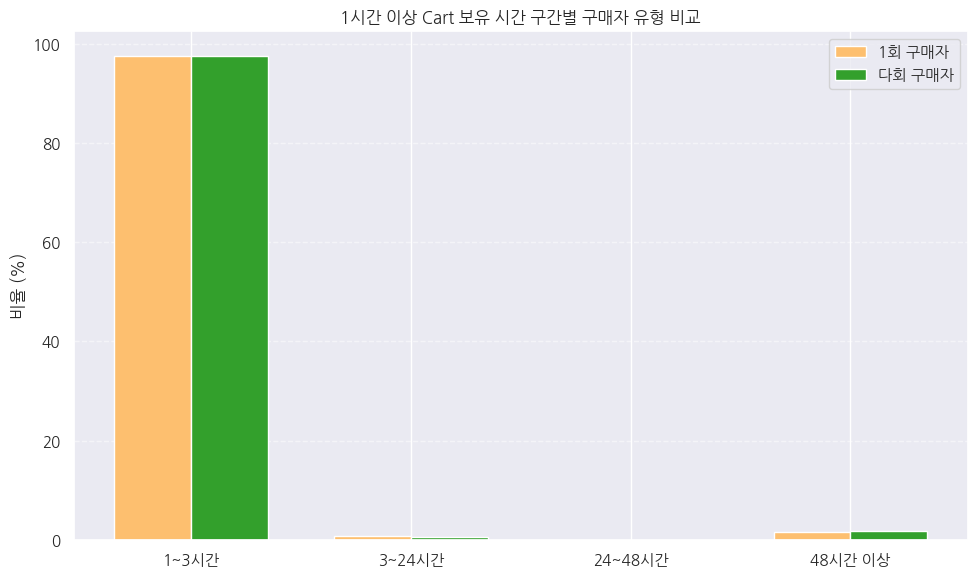

In [ ]:
# 1시간 이상만 다루므로 bins 조정
bins_1hplus = [1, 3, 24, 48, 9999]
labels_1hplus = ['1~3시간', '3~24시간', '24~48시간', '48시간 이상']

# cut
one_time_cut_1hplus = pd.cut(one_time_over1h, bins=bins_1hplus, labels=labels_1hplus, right=False)
multi_cut_1hplus = pd.cut(multi_over1h, bins=bins_1hplus, labels=labels_1hplus, right=False)

# 비율
one_time_ratio_1hplus = one_time_cut_1hplus.value_counts(normalize=True).sort_index()
multi_ratio_1hplus = multi_cut_1hplus.value_counts(normalize=True).sort_index()

import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(labels_1hplus))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, one_time_ratio_1hplus.values * 100, width, label='1회 구매자', color='#fdbf6f')
plt.bar(x + width/2, multi_ratio_1hplus.values * 100, width, label='다회 구매자', color='#33a02c')

plt.xticks(x, labels_1hplus)
plt.ylabel('비율 (%)')
plt.title('1시간 이상 Cart 보유 시간 구간별 구매자 유형 비교')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 🔎 1회, 2회 이상 구매자와 비교: 구매 전 행동 흐름 분석, 평균 세션 수, 평균 탐색 카테고리 수, 평균 브랜드 수

In [ ]:
# 1회 구매자 행동 흐름 분석
#2. 구매 전 행동 흐름
# 구매가 발생한 세션 이전 이벤트 시퀀스 파악
# 구매 이벤트가 있는 세션 ID 추출
purchase_sessions = notop_one_df[notop_one_df['event_type'] == 'purchase']['user_session'].unique()

# 해당 세션의 이벤트 순서 (view, cart, purchase)
funnel_sequence = (notop_one_df[notop_one_df['user_session'].isin(purchase_sessions)]
                   .groupby('user_session')['event_type']
                   .apply(list))

print(funnel_sequence.head(10))  # 세션별 행동 흐름 샘플

#3. 세션 수 & 행동량 분석
# 유저별 세션 수
user_session_count = notop_one_df.groupby('user_id')['user_session'].nunique()

# 유저별 이벤트 수
user_event_count = notop_one_df.groupby('user_id')['event_type'].count()

print(f"평균 세션 수: {user_session_count.mean()}")
print(f"평균 이벤트 수: {user_event_count.mean()}")

#4. 카테고리/브랜드 다양성
# 유저별 탐색 카테고리 수
user_category_diversity = notop_one_df.groupby('user_id')['category_lvl1'].nunique()

# 유저별 브랜드 수
user_brand_diversity = notop_one_df.groupby('user_id')['brand'].nunique()

print(f"평균 탐색 카테고리 수: {user_category_diversity.mean()}")
print(f"평균 브랜드 수: {user_brand_diversity.mean()}")

#5. 요일/시간대 분석
# # event_date를 datetime으로 변환
# notop_one_df['event_date'] = pd.to_datetime(notop_one_df['event_date'])

# 구매 이벤트만 추출
purchase_notop_one_df = notop_one_df[notop_one_df['event_type'] == 'purchase']

# 요일별 구매 수
weekday_purchase = purchase_notop_one_df['weekday'].value_counts()

# 시간대별 구매 수
hour_purchase = purchase_notop_one_df['event_hour'].value_counts().sort_index()

print("요일별 구매 수:\n", weekday_purchase)
print("시간대별 구매 수:\n", hour_purchase)

user_session
00001627-e6a6-4b93-8119-79227d8ab98e                [view, cart, purchase, view, view]
00002e63-e38d-4598-901f-99f7ffbae431                            [view, cart, purchase]
00007ab5-a0cf-4295-880f-e2612bdd8a19                [view, cart, view, cart, purchase]
00008e06-d2cb-4f9e-b41f-db3382ea5e7a                [view, cart, view, cart, purchase]
0001f68e-6c17-42d2-9a04-f4d594c3eee3                            [view, view, purchase]
00022da0-6765-47f6-8f44-aa06371c4f69                            [view, cart, purchase]
00024829-4081-48d4-9d02-e33399973edc    [view, view, view, view, view, cart, purchase]
00025dab-5cfa-4d21-960a-f0400a79e6f7          [view, cart, view, cart, purchase, view]
00026651-b032-4271-ada1-4514acdb25be                                        [purchase]
000268ba-f3af-4ec6-9660-beca1ff6413d                [view, cart, purchase, view, view]
Name: event_type, dtype: object
평균 세션 수: 8.951877499005455
평균 이벤트 수: 43.86074681914112
평균 탐색 카테고리 수: 2.98888469344409

In [ ]:
# 2회 이상 구매자 행동 흐름 분석
#1.구매 간격(재구매 주기)
# event_date를 datetime으로 변환
notop_multi_df['event_date'] = pd.to_datetime(notop_multi_df['event_date'])

# 구매 이벤트만 추출
purchase_notop_multi_df = notop_multi_df[notop_multi_df['event_type'] == 'purchase']

# 유저별 구매 일자 정렬
purchase_notop_multi_df = purchase_notop_multi_df.sort_values(by=['user_id', 'event_date'])

# 각 유저의 구매 간격 계산 (days)
purchase_notop_multi_df['purchase_gap'] = purchase_notop_multi_df.groupby('user_id')['event_date'].diff().dt.days

# 평균 구매 간격
avg_gap = purchase_notop_multi_df['purchase_gap'].mean()
print(f"평균 구매 간격(일): {avg_gap}")

#2. 구매 전 행동 흐름
# 구매가 발생한 세션 이전 이벤트 시퀀스 파악
# 구매 이벤트가 있는 세션 ID 추출
purchase_sessions = notop_multi_df[notop_multi_df['event_type'] == 'purchase']['user_session'].unique()

# 해당 세션의 이벤트 순서 (view, cart, purchase)
funnel_sequence = (notop_multi_df[notop_multi_df['user_session'].isin(purchase_sessions)]
                   .groupby('user_session')['event_type']
                   .apply(list))

print(funnel_sequence.head(10))  # 세션별 행동 흐름 샘플

#3. 세션 수 & 행동량 분석
# 유저별 세션 수
user_session_count = notop_multi_df.groupby('user_id')['user_session'].nunique()

# 유저별 이벤트 수
user_event_count = notop_multi_df.groupby('user_id')['event_type'].count()

print(f"평균 세션 수: {user_session_count.mean()}")
print(f"평균 이벤트 수: {user_event_count.mean()}")

#4. 카테고리/브랜드 다양성
# 유저별 탐색 카테고리 수
user_category_diversity = notop_multi_df.groupby('user_id')['category_lvl1'].nunique()

# 유저별 브랜드 수
user_brand_diversity = notop_multi_df.groupby('user_id')['brand'].nunique()

print(f"평균 탐색 카테고리 수: {user_category_diversity.mean()}")
print(f"평균 브랜드 수: {user_brand_diversity.mean()}")

#5. 요일/시간대 분석
# 요일별 구매 수
weekday_purchase = purchase_notop_multi_df['weekday'].value_counts()

# 시간대별 구매 수
hour_purchase = purchase_notop_multi_df['event_hour'].value_counts().sort_index()

print("요일별 구매 수:\n", weekday_purchase)
print("시간대별 구매 수:\n", hour_purchase)

평균 구매 간격(일): 8.708703408219074
user_session
00000361-1394-4fe6-a29b-4bed6c17193a                               [view, cart, purchase]
00001739-fd8f-4d65-b8c8-bb82e3e5af3a                               [view, cart, purchase]
00004e71-576e-4dd6-b322-0639305153a6                               [view, cart, purchase]
00005479-86e4-4988-b8b5-5ec5cabdb04d    [view, view, view, view, view, view, cart, pur...
00005e37-2de6-45af-a682-2fe5595fdd7e             [view, view, view, cart, purchase, view]
00006211-94ee-44ad-9fb1-a4bca0710818             [view, cart, view, view, cart, purchase]
00007576-a35c-4704-b276-3fecef2f6fc2             [view, view, view, cart, purchase, view]
00009f76-cbe9-46a7-8185-36dcddbd3c56    [view, view, view, view, view, cart, purchase,...
0000d0db-62c8-484e-a493-f5390b14f6d1    [view, view, view, view, view, view, view, vie...
0000dbc1-c195-4448-b3d4-40aff9d0a5b8                         [view, cart, purchase, view]
Name: event_type, dtype: object
평균 세션 수: 17.667503649635

| 항목               | **2회 이상 구매자**   | **1회 구매자**      | **차이점**                       |
| ---------------- | --------------- | --------------- | ----------------------------- |
| **평균 세션 수**      | 17.67           | 8.95            | 🔻 8.72개 감소 (약 **49%** ↓)     |
| **평균 이벤트 수**     | 96.83           | 43.86           | 🔻 52.97개 감소 (약 **55%** ↓)    |
| **평균 탐색 카테고리 수** | 3.93            | 2.99            | 🔻 약 **24%** 감소               |
| **평균 브랜드 수**     | 14.09           | 8.13            | 🔻 약 **42%** 감소               |
| **평균 구매 간격 (일)** | **8.71일**       | -               | (1회 구매자는 해당 없음)               |
| **주요 구매 요일**     | Mon > Sun > Tue | Sun > Mon > Tue | 주초(월) 중심 vs 주말(일) 중심 차이       |
| **주요 구매 시간대**    | 14시 > 13시 > 15시 | 14시 > 13시 > 15시 | 유사하지만 다회 구매자는 **이른 시간대**에도 활발 |

- 다회 구매자는 모든 항목에서 2배 이상 활발(탐색 의지 강하고 제품 비교 행동 활발), 첫 구매 전 고민 더 많음(cart 넣었다가 여러 번 view 하는 패턴 보임, 비교 및 추천 기능 강화 필요)
- 반면, 1회 구매자는 단발성 구매 행동 위주
- 구매 간격: 다회 구매자는 평균 1주일 내 재구매 -> 리타겟팅 타이밍이 핵심
- 재방문 유도 포인트: 1회 구매자에게도 브랜드 비교, 다양한 추천 제공이 구매 결정에 긍정적일 수도, 특히 13-15시/주말~월요일 타이밍에 마케팅 집중하면 좋음
- 1회는 주말/오후, 다회는 평일/오전부터 고르게 활발